## 0. SET-UP
---

### Libraries and and Utilities

In [1]:
# Load libaries -----

import pandas as pd
import numpy as np
import datetime as dt

# stats
from scipy.stats import ttest_ind, randint, chi2_contingency

# modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# visuals
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.tree import plot_tree
import seaborn as sns

# system
import sys
import os
import warnings

In [2]:
# Import my own functions -----

module_path = os.path.abspath(os.path.join('functions'))
if module_path not in sys.path:
    sys.path.append(module_path)

import data_clean
import plot

In [3]:
# Settings -----

warnings.filterwarnings('ignore', category=FutureWarning)

# downloads (if needed)
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/windywang2022-1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/windywang2022-1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. INTRODUCTION
---

### 1.1 About the Data

Steam is a digital distribution platform developed by Valve Corporation for purchasing and playing video games. The platform offers access to thousands of games from a variety of developers and publishers, with features such as cloud saving, in-game voice and chat, and community forums. It also provides tools for game developers to create and sell their own games on the platform. Steam is available on Windows, macOS, and Linux operating systems, as well as on mobile devices through the Steam mobile app.

The data is sourced from 3 datasets on Kaggle: (1) [Game Recommendations on Steam](https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam?select=games.csv), (2) [Steam Store Games (Clean dataset)](https://www.kaggle.com/datasets/nikdavis/steam-store-games), and (3) [Metacritic Games](https://www.kaggle.com/datasets/henrylin03/metacritic-games-user-reviews-and-metascores). The three data sets were combined together in order to answer questions in this analysis. The *Game Recommendations on Steam* contains cleaned and preprocessed 10M+ samples of user recommendations (reviews) from the Steam store. Additionally, it contains detailed information about games and add-ons. The *Steam Store Games* dataset provides information about various aspects of games on the Steam store, such as its genre, developer, and average playtime. It includes most games released prior to May 2019. Some of the data was scraped from SteamSpy, which is a website that provides estimates of game sales and player counts on the Steam platform, based on publicly available data. The *Metacritic Games* dataset contains Metacritic review scores from critics and users.
<br/><br/>

There are 3 files included in the *Game Recommendations on Steam* dataset, and a brief description of each is included below:

**games.csv**  
A table of games (or add-ons) information on ratings, pricing in US dollars $, release date, etc.

**users.csv**   
A table of user profiles' public information: the number of purchased products and reviews published.

**recommendations.csv**  
a table of user reviews: whether the user recommends a product. The table represents a many-many relation between a game entity and a user entity.
<br/><br/>

There are 5 files included in the *Steam Store Games* dataset, and a brief description of each is included below:

**steam.csv**  
Game data from Steam. Each row has a unique AppID and is usually a separate release, excepting some re-releases and remasters.

**steam_description_data.csv**   
Includes descriptions about each games.

**steam_media_data.csv**  
Contains links to screenshots, images and movies. Will not be used for analysis.

**steam_requirements_data.csv**  
Includes system requirements information for each platform. Will not be used for analysis.

**steam_support_info.csv**  
Contains website, support url and support email for games that have them. Will not be used for analysis.

**steamspy_tag_data.csv**  
Contains tags from SteamSpy and the number of votes for each tag for each game. Higher numbers can be considered more strongly associated with that tag. Will not be used for analysis due to time constraints.
<br/><br/>

There is 1 file included in the *Metacritic Games* dataset, and a brief description of it is included below:  

**meta_games.csv**  
Each row contains an unique game and its associated platform, release date, summary, metacritic score, and user review.
<br/><br/>

### 1.2 Problem Statement
The video game industry has been rapidly growing in recent years and the availability of digital distribution platforms, such as Steam, has made it easier for game developers to reach a wider audience. With the massive amounts of data generated by these platforms, it is important to use data science techniques to analyze this data in order to gain insights into the video game market.

The goal of this project is to perform descriptive and predictive analysis on three video game datasets from Kaggle - the "Game Recommendations on Steam" dataset, "Steam Store Games" dataset, and the "Metacritic Games" dataset. With these datasets, the aim of this project is to answer several questions such as:

* What are some diferences between free/paid games on the Steam store?
* What are some differences between games with high estimated owners vs low estimated owners?
* Which games are the highest rated by Metacritic critics vs gamers? Are there any overlap?
* Was there a "golden era" for video games?
* Is there a relationship between user ratings and cost of the game?
* Are there any trends in video game releases dates?
* Can we predict a game's success based on its attributes, such as genre, release date, and user reviews?
* Can we predict if an user would recommend a game to others?
* Can we correctly tag video games by genre based on their description?

By answering these questions, we can gain a better understanding of the video game market and provide insights that can help game developers and publishers make more informed decisions.
<br/><br/>

### 1.3 Read and Preview Data

Let's start by reading in the data.

In [4]:
# Read in data -----

df_games = pd.read_csv('data/steam-game-recommendations/games.csv', parse_dates=['date_release'])
df_recs = pd.read_csv('data/steam-game-recommendations/recommendations.csv')
df_users = pd.read_csv('data/steam-game-recommendations/users.csv')

df_steam = pd.read_csv('data/steam-games/steam.csv', parse_dates=['release_date'])
df_description = pd.read_csv('data/steam-games/steam_description_data.csv')

df_metacritic = pd.read_csv('data/steam-metacritic/meta_games.csv', parse_dates=['release_date'])

Next, we can preview each of the datasets. My function, `preview_data`, shows the first 5 rows of the DataFrame and outputs it in Markdown format. A function was used to reduce code redundancy and enable quicker and more consistent edits to the output. All functions can be found under the `/function` directory.

In [5]:
# Preview the first 5 rows of games.csv
print(data_clean.preview_data(df_games))

|   app_id | title                             | date_release        | win   | mac   | linux   | rating        |   positive_ratio |   user_reviews |   price_final |   price_original |   discount | steam_deck   |
|---------:|:----------------------------------|:--------------------|:------|:------|:--------|:--------------|-----------------:|---------------:|--------------:|-----------------:|-----------:|:-------------|
|    10090 | Call of Duty: World at War        | 2008-11-18 00:00:00 | True  | False | False   | Very Positive |               92 |          37039 |         19.99 |            19.99 |          0 | True         |
|    13500 | Prince of Persia: Warrior Within™ | 2008-11-21 00:00:00 | True  | False | False   | Very Positive |               84 |           2199 |          9.99 |             9.99 |          0 | True         |
|    22364 | BRINK: Agents of Change           | 2011-08-03 00:00:00 | True  | False | False   | Positive      |               85 |             21 |    

In [6]:
# Preview the first 5 rows of recommendations.csv
print(data_clean.preview_data(df_recs))

|   app_id |   helpful |   funny | date       | is_recommended   |   hours |   user_id |   review_id |
|---------:|----------:|--------:|:-----------|:-----------------|--------:|----------:|------------:|
|   975370 |         0 |       0 | 2022-12-12 | True             |    36.3 |     21058 |           0 |
|   304390 |         4 |       0 | 2017-02-17 | False            |    11.5 |      1153 |           1 |
|  1085660 |         2 |       0 | 2019-11-17 | True             |   336.5 |     96124 |           2 |
|   703080 |         0 |       0 | 2022-09-23 | True             |    27.4 |     98074 |           3 |
|   526870 |         0 |       0 | 2021-01-10 | True             |     7.9 |      9634 |           4 |


In [7]:
# Preview the first 5 rows of users.csv
print(data_clean.preview_data(df_users))

|     user_id |   products |   reviews |
|------------:|-----------:|----------:|
| 6.04325e+06 |        156 |         1 |
| 3.80278e+06 |        329 |         3 |
| 2.05375e+06 |        176 |         2 |
| 2.21433e+06 |         98 |         2 |
| 2.45172e+06 |        144 |         3 |


In [8]:
# Preview the first 5 rows of steam.csv
print(data_clean.preview_data(df_steam))

|   appid | name                      | release_date        |   english | developer        | publisher   | platforms         |   required_age | categories                                                                   | genres   | steamspy_tags                |   achievements |   positive_ratings |   negative_ratings |   average_playtime |   median_playtime | owners            |   price |
|--------:|:--------------------------|:--------------------|----------:|:-----------------|:------------|:------------------|---------------:|:-----------------------------------------------------------------------------|:---------|:-----------------------------|---------------:|-------------------:|-------------------:|-------------------:|------------------:|:------------------|--------:|
|      10 | Counter-Strike            | 2000-11-01 00:00:00 |         1 | Valve            | Valve       | windows;mac;linux |              0 | Multi-player;Online Multi-Player;Local Multi-Player;Valve Anti-Che

In [9]:
# Preview the first 5 rows of steam_description_data.csv
print(data_clean.preview_data(df_description))

|   steam_appid | detailed_description                                                                                                                                                                                                                                                                                                                                                                                                                         | about_the_game                                                                                                                                                                                                                                                                                                                                                                                                                               | short_description                                                                                                       

In [10]:
# Preview the first 5 rows of meta_games.csv
print(data_clean.preview_data(df_metacritic))

| name                                         | platform   | release_date        | summary                                                                                                                                                                                                                                                                                                                                                                                                                          | metascore   | userscore   |
|:---------------------------------------------|:-----------|:--------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<br></br>
### 1.4 Joining Datasets and Processing

Based on my problem statement and questions I wanted to address, I will create 3 dataframes for analysis. 
1. **df** - main dataframe for analysis, will contain information from `df_games`, `df_steam`, and `df_metacritic`
2. **df_descript** - focuses on text-based columns for bag-of-words classification
3. **df_user** - focuses on user reviews and recommendations from the Steam store
<br></br>

**1 | df**  

In [11]:
# First, make sure the str columns are clean (this takes a while, but I noticed some str columns have trailing whitespaces)
df_steam = data_clean.strip_df(df_steam)
df_metacritic = data_clean.strip_df(df_metacritic)
df_description = data_clean.strip_df(df_description)
df_games = data_clean.strip_df(df_games)
df_recs = data_clean.strip_df(df_recs)
df_users = data_clean.strip_df(df_users)

In [12]:
# Clean metacritic data ---
df_metacritic = df_metacritic.dropna()
df_metacritic = df_metacritic[df_metacritic['platform'].isin(['PC'])]
df_metacritic['userscore'] = pd.to_numeric(df_metacritic['userscore'], errors='coerce') # ignore 'tbd' entries
df_metacritic['metascore'] = pd.to_numeric(df_metacritic['metascore'], errors='coerce') # ignore 'tbd' entries
df_metacritic['metascore'] = df_metacritic.groupby(['name', 'release_date'])['metascore'].transform('mean')
df_metacritic['userscore'] = df_metacritic.groupby(['name', 'release_date'])['userscore'].transform('mean')
df_metacritic = df_metacritic.drop_duplicates()

# only keep the most recent re-release
df_metacritic = df_metacritic.sort_values('release_date', ascending=False).groupby('name').first().reset_index()

In [13]:
# Join game data with steam data ---
df = pd.merge(
    left=df_games,
    right=df_steam,
    how='left',
    left_on='app_id',
    right_on='appid'
).drop_duplicates()

# Consolidate similar columns to maximize information (fill missing from first column with values from second column)
df['date_release'] = df['date_release'].fillna(df['release_date'])
df['title'] = df['title'].fillna(df['name'])

# Drop unneeded columns
cols_to_drop = [
    'appid',
    'name',
    'platforms',
    'release_date',
    'price'
]
df = df.drop(columns=cols_to_drop)

# Join again with df_metacritic ---
df = pd.merge(
    left=df,
    right=df_metacritic[['name', 'metascore', 'userscore']],
    how='left',
    left_on='title',
    right_on='name'
).drop_duplicates()

df = df.drop(columns=['name'])

# Add variables ---

# adding year variable
df['release_year'] = df['date_release'].dt.year

# adding month of release, as this might be interesting (e.g. holidays might drive sales or influence rating)
df['release_month'] = df['date_release'].dt.strftime('%B')
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df['release_month'] = pd.Categorical(df['release_month'], categories=month_order, ordered=True)

# ading day of week variable
df['release_dayofweek'] = df['date_release'].dt.day_name()
dayofweek_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['release_dayofweek'] = pd.Categorical(df['release_dayofweek'], categories=dayofweek_order, ordered=True)

# Correct the ordering of the 'owners' column ---
owner_cat_order = [
    '0-20000',
    '20000-50000',
    '50000-100000',
    '100000-200000',
    '200000-500000',
    '500000-1000000',
    '1000000-2000000',
    '2000000-5000000',
    '5000000-10000000',
    '10000000-20000000',
    '20000000-50000000',
    '50000000-100000000',
    '100000000-200000000'
]
df['owners'] = pd.Categorical(df['owners'], categories=owner_cat_order, ordered=True)

# Preview output ---
data_clean.print_shape(df, 'df')
print()
print('Preview data:')
print(data_clean.preview_data(df))

The dataframe 'df' has 48318 rows and 31 columns.

Preview data:
|   app_id | title                             | date_release        | win   | mac   | linux   | rating        |   positive_ratio |   user_reviews |   price_final |   price_original |   discount | steam_deck   |   english | developer         | publisher         |   required_age | categories                                                                                                                                                                                                         | genres                                 | steamspy_tags              |   achievements |   positive_ratings |   negative_ratings |   average_playtime |   median_playtime | owners          |   metascore |   userscore |   release_year | release_month   | release_dayofweek   |
|---------:|:----------------------------------|:--------------------|:------|:------|:--------|:--------------|-----------------:|---------------:|--------------:|----

In [14]:
# Check if there are any duplicate app_ids ---
data_clean.check_duplicate_ids(df, 'app_id')

Data is clean, each row is a unique app_id.


In [15]:
# Check column types and fix as needed ---

# Fix column types
df['app_id'] = df['app_id'].astype(str)
df['english'] = df['english'].astype(bool)
df['userscore'] = pd.to_numeric(df['userscore'], errors='coerce') # ignore 'tbd' entries

# Check final column type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48318 entries, 0 to 48317
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   app_id             48318 non-null  object        
 1   title              48318 non-null  object        
 2   date_release       48318 non-null  datetime64[ns]
 3   win                48318 non-null  bool          
 4   mac                48318 non-null  bool          
 5   linux              48318 non-null  bool          
 6   rating             48318 non-null  object        
 7   positive_ratio     48318 non-null  int64         
 8   user_reviews       48318 non-null  int64         
 9   price_final        48318 non-null  float64       
 10  price_original     48318 non-null  float64       
 11  discount           48318 non-null  float64       
 12  steam_deck         48318 non-null  bool          
 13  english            48318 non-null  bool          
 14  develo

In [16]:
# Check missing values
df.isnull().sum()

app_id                   0
title                    0
date_release             0
win                      0
mac                      0
linux                    0
rating                   0
positive_ratio           0
user_reviews             0
price_final              0
price_original           0
discount                 0
steam_deck               0
english                  0
developer            29711
publisher            29721
required_age         29711
categories           29711
genres               29711
steamspy_tags        29711
achievements         29711
positive_ratings     29711
negative_ratings     29711
average_playtime     29711
median_playtime      29711
owners               29711
metascore            44805
userscore            42423
release_year             0
release_month            0
release_dayofweek        0
dtype: int64

This is not a surprise, since I left-joined the data. I expect to see missing values from the new dataframes that I added. I will account for this later in analysis.

**2 | df_descript**  
In addition to the above data, I also want to conslidate a seperate dataframe for language-based analysis (i.e. features that contain descriptors and summaries of the games). First, I joined `df_description` with `df_steam` to get the 'name' column from `df_steam`. Then, I joined in `df_metacritic` using 'name' as the key.

In [17]:
# Merge data ---

# get 'name' and 'genre' column
df_descript = pd.merge(
    left=df_description,
    right=df_steam[['appid', 'name', 'genres']],
    left_on='steam_appid',
    right_on='appid'
).reset_index(drop=True)

# merge with df_metacritic on 'name'
df_descript = pd.merge(
    left=df_descript,
    right=df_metacritic,
    on='name'
)

# drop unncessary columns
cols_to_drop = [
    'appid',
    'release_date',
    'platform'
]
df_descript = df_descript.drop(columns=cols_to_drop)

# preview output
data_clean.print_shape(df_descript, 'df_descript')
print()
print('Preview data:')
print(data_clean.preview_data(df_descript))

The dataframe 'df_descript' has 15375 rows and 9 columns.

Preview data:
|   steam_appid | detailed_description                                                                                                                                                                                                                                                                                                                                                                                                                         | about_the_game                                                                                                                                                                                                                                                                                                                                                                                                                               | short_description                              

In [18]:
# Check if there are any duplicate app_ids ---
data_clean.check_duplicate_ids(df_descript, 'steam_appid')

Data is clean, each row is a unique steam_appid.


In [19]:
# Check column types and fix as needed ---

# fix column types
df_descript['steam_appid'] = df_descript['steam_appid'].astype(str)
df_descript['userscore'] = pd.to_numeric(df_descript['userscore'], errors='coerce') # ignore 'tbd' entries

# check final column type
df_descript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15375 entries, 0 to 15374
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   steam_appid           15375 non-null  object 
 1   detailed_description  15375 non-null  object 
 2   about_the_game        15375 non-null  object 
 3   short_description     15375 non-null  object 
 4   name                  15375 non-null  object 
 5   genres                15375 non-null  object 
 6   summary               15375 non-null  object 
 7   metascore             2289 non-null   float64
 8   userscore             4308 non-null   float64
dtypes: float64(2), object(7)
memory usage: 1.1+ MB


In [20]:
# Check missing values ---
df_descript.isnull().sum()

steam_appid                 0
detailed_description        0
about_the_game              0
short_description           0
name                        0
genres                      0
summary                     0
metascore               13086
userscore               11067
dtype: int64

**3 | df_user**  
Lastly, I want to create a dataframe for users.

In [21]:
# Merge df_users with df_recs by user_id (unique ID of resulting df is review_id) ---
df_user = pd.merge(
    left=df_recs,
    right=df_users,
    how='left',
    on='user_id'
)

# Preview output
data_clean.print_shape(df_user, 'df_user')
print()
print('Preview data:')
print(data_clean.preview_data(df_user))

The dataframe 'df_user' has 11265799 rows and 10 columns.

Preview data:
|   app_id |   helpful |   funny | date       | is_recommended   |   hours |   user_id |   review_id |   products |   reviews |
|---------:|----------:|--------:|:-----------|:-----------------|--------:|----------:|------------:|-----------:|----------:|
|   975370 |         0 |       0 | 2022-12-12 | True             |    36.3 |     21058 |           0 |         28 |         3 |
|   304390 |         4 |       0 | 2017-02-17 | False            |    11.5 |      1153 |           1 |        269 |         1 |
|  1085660 |         2 |       0 | 2019-11-17 | True             |   336.5 |     96124 |           2 |        237 |         2 |
|   703080 |         0 |       0 | 2022-09-23 | True             |    27.4 |     98074 |           3 |          5 |         2 |
|   526870 |         0 |       0 | 2021-01-10 | True             |     7.9 |      9634 |           4 |         13 |         2 |


In [22]:
# Check column types and fix as needed ---

# Fix column types
df_user['app_id'] = df_user['app_id'].astype(str)
df_user['user_id'] = df_user['user_id'].astype(str)
df_user['review_id'] = df_user['review_id'].astype(str)
df_user['date'] = pd.to_datetime(df_user['date'])

# check final column type
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11265799 entries, 0 to 11265798
Data columns (total 10 columns):
 #   Column          Dtype         
---  ------          -----         
 0   app_id          object        
 1   helpful         int64         
 2   funny           int64         
 3   date            datetime64[ns]
 4   is_recommended  bool          
 5   hours           float64       
 6   user_id         object        
 7   review_id       object        
 8   products        int64         
 9   reviews         int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 784.3+ MB


In [23]:
# Check if there are any duplicate review_ids ---
data_clean.check_duplicate_ids(df_user, 'review_id')

Data is clean, each row is a unique review_id.


In [87]:
# Check missing values ---
df_user.isnull().sum()

app_id            0
helpful           0
funny             0
date              0
is_recommended    0
hours             0
user_id           0
review_id         0
products          0
reviews           0
dtype: int64

<br></br>

## 2. DATA EXPLORATION
---

Exploratory data analysis will focus on the main dataframe `df`. First, we will check the descriptive statistics of numerical features.

In [24]:
# Descriptive stats of numerical data from steam.csv ---
df.describe()

date_release  positive_ratio  user_reviews   
count                          48318    48318.000000  4.831800e+04  \
mean   2019-01-10 07:58:46.685707264       76.917360  1.767661e+03   
min              1997-06-30 00:00:00        0.000000  1.000000e+01   
25%              2017-02-09 00:00:00       67.000000  2.000000e+01   
50%              2019-06-06 00:00:00       81.000000  5.100000e+01   
75%              2021-07-06 00:00:00       91.000000  2.150000e+02   
max              2023-04-27 00:00:00      100.000000  6.941137e+06   
std                              NaN       18.178726  3.816821e+04   

        price_final  price_original      discount  required_age  achievements   
count  48318.000000    48318.000000  48318.000000  18607.000000  18607.000000  \
mean       8.665583        9.197367      5.084172      0.420057     47.388080   
min        0.000000        0.000000      0.000000      0.000000      0.000000   
25%        0.990000        1.990000      0.000000      0.000000      0.000000   
50%        4.990000        4.990000      0.000000      0.000000     10.000000   
75%       11.240000       12.990000      0.000000      0.000000     27.000000   
max      299.990000      299.990000     90.000000     18.000000   9821.000000   
std       11.467465       11.760541     18.005386      2.617042    347.438538   

       positive_ratings  negative_ratings  average_playtime  median_playtime   
count      1.860700e+04      18607.000000      18607.000000     18607.000000  \
mean       1.390191e+03        288.384533        189.773795       176.779707   
min        0.000000e+00          0.000000          0.000000         0.000000   
25%        1.700000e+01          5.000000          0.000000         0.000000   
50%        4.900000e+01         16.000000          0.000000         0.000000   
75%        2.310000e+02         68.000000         20.000000        22.000000   
max        2.644404e+06     487076.000000     190625.000000    190625.000000   
std        2.275437e+04       5159.190036       2028.375509      2350.888685   

         metascore    userscore  release_year  
count  3513.000000  5895.000000  48318.000000  
mean     71.581839     6.868176   2018.519993  
min      20.000000     0.000000   1997.000000  
25%      66.000000     6.200000   2017.000000  
50%      73.000000     7.200000   2019.000000  
75%      79.000000     7.900000   2021.000000  
max      96.000000     9.800000   2023.000000  
std      10.341640     1.443585      3.050608

Conclusions:
* A game costs about $9.20 on average, with a standard deviation of $11.76
* If you purchased every game on sale, it would only save you about $1 on average
* The highest required age for any video game is 18+, but it seems like most games do not have a required age
* Average playtime is slightly higher than median playtime, likely due to some enthusiast or dedicated fans
* Metacritic critic score average 72/100 with a standard deviation of 10.3
* Metacritic user score averages 7/10 with a standard deviation of 1.5

<br></br>
### 2.1 Owners

I'm interested in finding out about which games have the highest estimated owners. Unfortunately there is no granular owner data (continuous); the owner variable is instead categorized in bins.

In [25]:
# Number of games owned in each owner bin ---
df['owners'].value_counts()

owners
0-20000                11071
20000-50000             2686
50000-100000            1498
100000-200000           1217
200000-500000           1138
500000-1000000           476
1000000-2000000          270
2000000-5000000          181
5000000-10000000          44
10000000-20000000         20
20000000-50000000          3
50000000-100000000         2
100000000-200000000        1
Name: count, dtype: int64

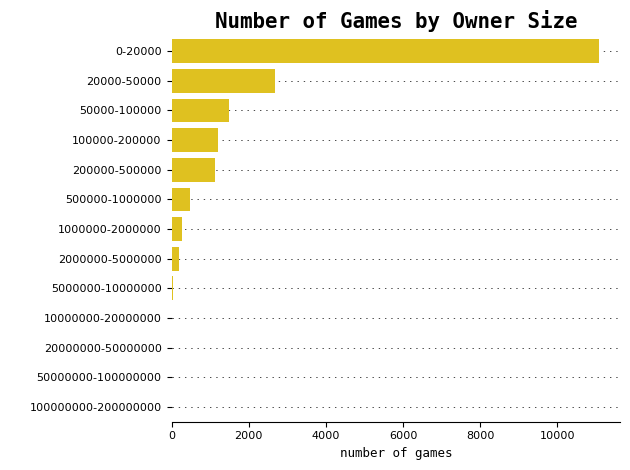

In [26]:
# Plot counts of games in each owner size category ---
# note: did not use plot.plot_counts function because I wanted to keep owners on y axis

fig, ax = plt.subplots()

sns.countplot(
    data=df,
    y='owners',
    ax=ax,
    color='gold',
    zorder=2
)

plt.title('Number of Games by Owner Size', fontsize=15, fontweight='bold', fontfamily='monospace', loc='center')
ax.set_xlabel('number of games', fontsize=9, fontfamily='monospace')
ax.set_ylabel(' ')

ax.grid(which='both', axis='y', linestyle=':', linewidth=0.5, color='black', dashes=(2,7))
ax.tick_params(axis='both', labelsize=8)
for direction in ['top','right','left']:
    ax.spines[direction].set_visible(False)

plt.tight_layout()
plt.show()

Interestingly, there appears to be only 6 games total in the highest bins, meaning there are only 6 games which have over 20000000+ estimated owners. I hypothesize that these games will be either free, or have a very low price.

In [27]:
# Add column to indicate if game is free or not ---
df['is_free'] = np.where(df['price_original'] == 0, True, False)

In [28]:
# Check which games have the highest owners, and if they are free ---
print(df.sort_values(by='owners', ascending=False)[['title', 'owners', 'is_free']].head(6).to_markdown(index=False))

| title                            | owners              | is_free   |
|:---------------------------------|:--------------------|:----------|
| Dota 2                           | 100000000-200000000 | True      |
| PUBG: BATTLEGROUNDS              | 50000000-100000000  | True      |
| Counter-Strike: Global Offensive | 50000000-100000000  | True      |
| Team Fortress 2                  | 20000000-50000000   | True      |
| Warframe                         | 20000000-50000000   | True      |
| Unturned                         | 20000000-50000000   | True      |


Conclusions:
* Majority of games have less than 20000 owners
* The game that is owned by the the most number of people is Dota 2 with over 100000000+ owners, followed by PUBG and CS:GO
* It is also interesting to note that all the top owned games are free; this makes sense as free games are accessible to more people
<br></br>

### 2.2 Price

Next, I will look into the price of games. I will focus on the feature `price_original` for the purposes of this analysis.

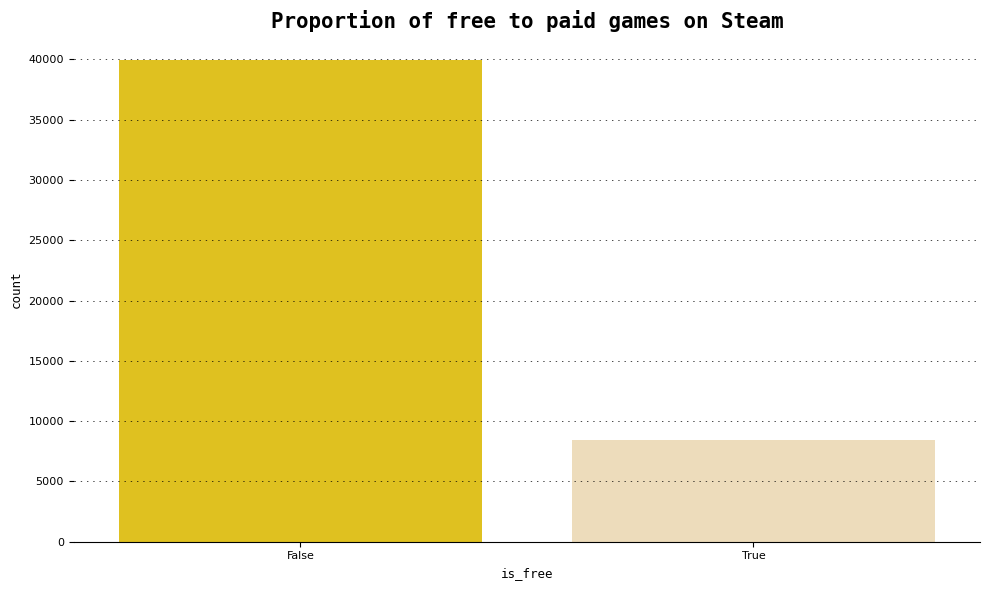

In [29]:
plot.plot_counts(
    data=df,
    var_group='is_free',
    var_to_count='title',
    title='Proportion of free to paid games on Steam'
)

There are more than 4x as many paid games as free games. This is quite interesting, considering that of all the games on Steam, even though there are so many more paid games, the games which are owned by the most number of people are free. It also makes sense, as Steam as a platform earns revenue through the sale of games.

Next, let's check the distribution of price.

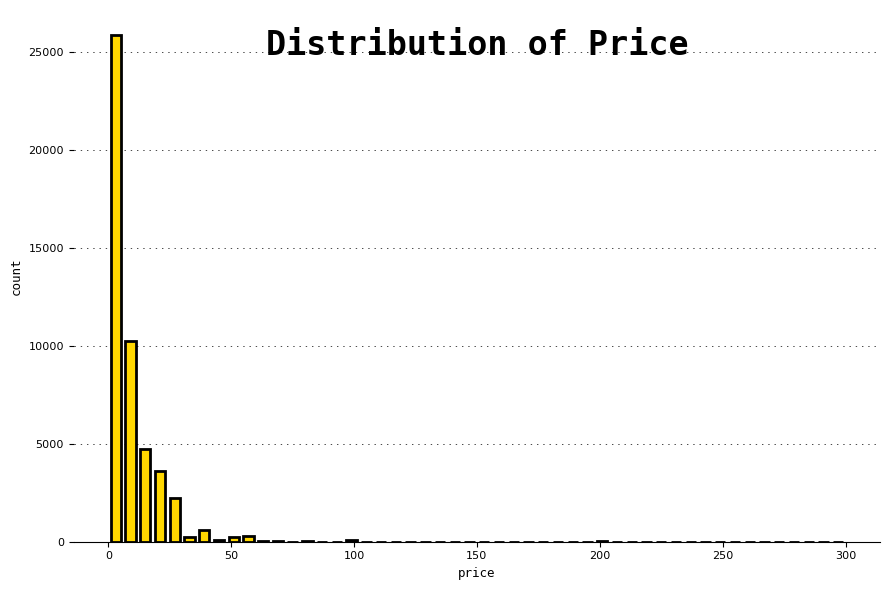

In [30]:
plot.plot_histogram(
    data=df,
    num_var='price_original',
    bin=6,
    title='Distribution of Price',
    xlab='price'
)

This distribution is quite right-skewed, meaning there are a lot more cheaper games compared to very expensive games.

In [31]:
# Check the top 10 most expensive games
print(data_clean.preview_top_x(df, 'price_original', 10))

| title                                  |   price_original |
|:---------------------------------------|-----------------:|
| Clickteam Fusion 2.5 Developer Upgrade |           299.99 |
| Aartform Curvy 3D 3.0                  |           299.9  |
| Houdini Indie                          |           269.99 |
| Hidden World 4 Top-Down 3D             |           199.99 |
| Hidden Harbor 3 Top-Down 3D            |           199.99 |
| Fly Fly Tuk Tuk                        |           199.99 |
| Supreme Race on Highway                |           199.99 |
| Derelict (DO NOT BUY)                  |           199.99 |
| 3DF Zephyr Lite Steam Edition          |           199.99 |
| The King's Castle                      |           199.99 |


The most expensive games seem to be mostly engines used to build games, or meme games. After speaking with some experts (gaming friends), these games do not seem like they would be too relevant for our analysis, which hopes to focus on the games more people enjoy playing.

Therefore, to get a better idea of the data distribution, I removed any games >3 standard deviations on the upper-end and graphed the resulting distribution.

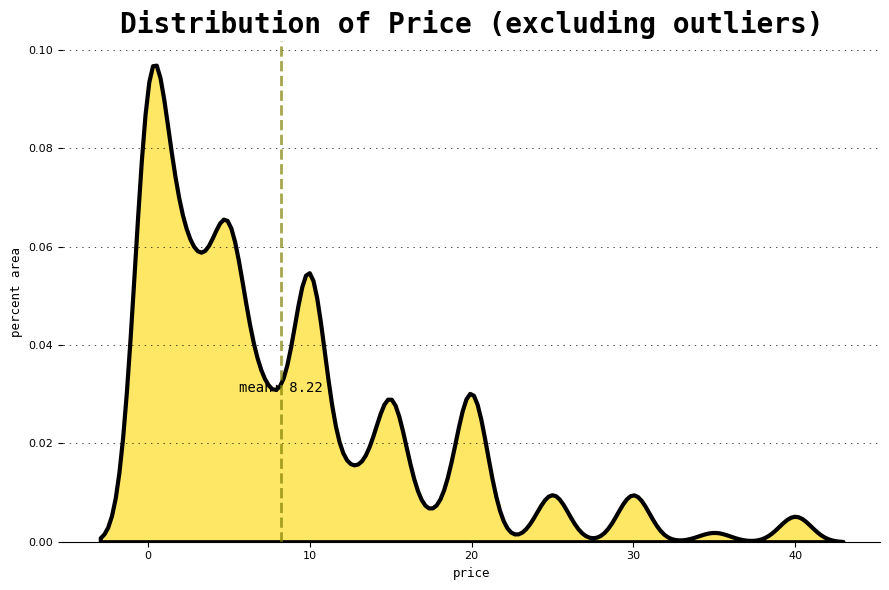

In [32]:
# Density plot of price (using only games with price < 3 std of the mean) ---
price_xoutliers = data_clean.remove_upper_outliers(df, 'price_original', 3)

plot.plot_distribution(
    data=price_xoutliers,
    num_var='price_original',
    title='Distribution of Price (excluding outliers)',
    xlab='price'
)

Still right-skewed, but much better than before. Most games are <$10 (with a mean cost of $8.22), and there seems to be a preference to price games in multiples of 5 (there is a peak at $5, $10, $15, $20, etc.), which is quite interesting! Perhaps humans enjoy to see price values ending in 0s and 5s.

Conclusions:
* There are almost 4x as many paid games as free games.
* There are a few games which cost much more than the average, but they tend to be engines or idle games.
* After removing outliers, the average cost of a game on Steam is $8.22 USD.
* There seems to be a preference to price games in multiples of 5 (there is a peak at $5, $10, $15, $20, etc.).
<br></br>

### 2.3 Ratings

Following that, let's see how well games are rated by different sources. In particular, I'm interested to see if there are any differences in the ratings between free vs paid games.

**2.3.1 Metacritic critic scores**  

First, let's examine the Metacritic critic ratings for games, which are collected from a variety of professional game critics and sites (e.g. Kotaku, IGN). These scores are out of 100, and can be found on [metacrtic.com](www.metacritic.com).

In [33]:
# Top 10 games by their Metacritic critic score ---
print(data_clean.preview_top_x(df, 'metascore', 10))

| title              |   metascore |
|:-------------------|------------:|
| Grand Theft Auto V |          96 |
| Half-Life 2        |          96 |
| Half-Life          |          96 |
| Portal 2           |          95 |
| Persona 5 Royal    |          95 |
| BioShock Infinite  |          94 |
| Quake              |          94 |
| Half-Life: Alyx    |          93 |
| Company of Heroes  |          93 |
| God of War         |          93 |


In [34]:
# Bottom 10 games by their Metacritic critic score ---
print(data_clean.preview_bottom_x(df, 'metascore', 10))

| title                        |   metascore |
|:-----------------------------|------------:|
| Citadels                     |          20 |
| Postal III                   |          24 |
| Overlord: Fellowship of Evil |          24 |
| Rogue Warrior                |          29 |
| Sniper Rust VR               |          29 |
| Shaq Fu: A Legend Reborn     |          30 |
| POSTAL 4: No Regerts         |          30 |
| Zombeer                      |          32 |
| Majestic Nights              |          32 |
| X Rebirth                    |          33 |


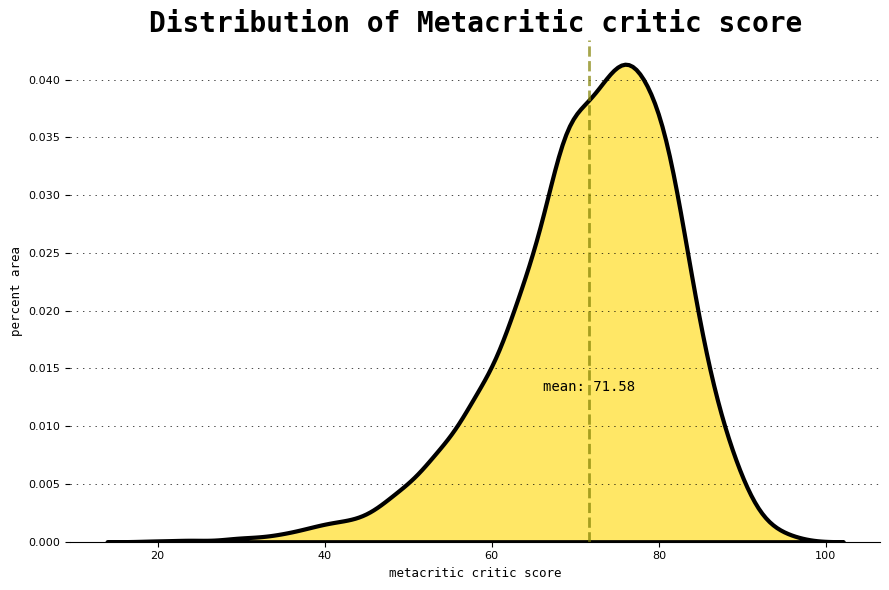

In [35]:
# Density plot of metacritic critic score ---

plot.plot_distribution(
    data=df,
    num_var='metascore',
    title='Distribution of Metacritic critic score',
    xlab='metacritic critic score'
)

Conclusions:
* The top games of all time have a score of 96/100 (tied between Grand Theft Auto V, Half-Life 2, and Half-Life)
* The worst game of all time (Citadels) has a score of 20/100
* The distribution has a mean score of 71.58/100
* In terms of ratings, it means that Metacritic's critics think that an "average" game is around 70/100, instead of ~50/100
* Then consulting scores for new games, we would need to keep in mind that scoring skews positive
<br></br>

**2.3.2 Metacritic user scores**  

We can also check the top-rated games based on users (everyday gamers) from [metacritic.com](www.metacritic.com). These scores are out of 10.

In [36]:
# Top 10 games by their user review score ---
print(data_clean.preview_top_x(df, 'userscore', 10))

| title                                |   userscore |
|:-------------------------------------|------------:|
| Resident Evil                        |         9.8 |
| Age of Wonders                       |         9.2 |
| Half-Life 2: Episode Two             |         9.2 |
| Touken Ranbu Warriors                |         9.2 |
| Utawarerumono: Prelude to the Fallen |         9.2 |
| Portal                               |         9.2 |
| Half-Life 2                          |         9.2 |
| POPGOES Arcade                       |         9.2 |
| Counter-Strike                       |         9.2 |
| The Evil Within: The Assignment      |         9.2 |


When compared to the top 10 games from Metacritic's critics, only 2 games overlap:
* Portal
* Half-Life 2

In [37]:
# Bottom 10 games by their user review score ---
print(data_clean.preview_bottom_x(df, 'userscore', 10))

| title                                   |   userscore |
|:----------------------------------------|------------:|
| Pinball FX                              |         0   |
| Madden NFL 22                           |         0.6 |
| Police Simulator: Patrol Duty           |         0.6 |
| Aeon Must Die!                          |         0.8 |
| Grindstone                              |         0.8 |
| Blanc                                   |         0.8 |
| Madden NFL 23                           |         0.9 |
| Evil Inside                             |         0.9 |
| Erzurum                                 |         1   |
| Tiny Tina's Wonderlands: Coiled Captors |         1.1 |


There is no overlap between user's bottom 10 and critic's bottom 10. Perhaps this is because there are a wider selection of games which are rated poorly compared to rated highly.

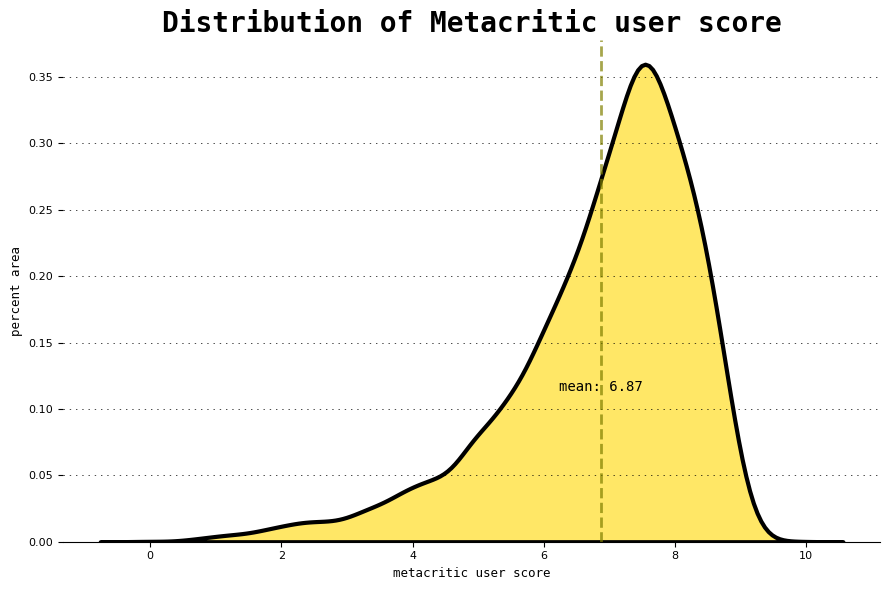

In [38]:
# Density plot of metacritic user score ---

plot.plot_distribution(
    data=df,
    num_var='userscore',
    title='Distribution of Metacritic user score',
    xlab='metacritic user score'
)

Conclusions:
* The top game of all time (Resident Evil) has a score of 9.8/10
* The worst game of all time (Pinball FX) has a score of 0/10
* Portal and Half-Life 2 appeared on the top 10 list of both critics and users
* There is no overlap between the lowest rated games compared to critic scores; it is easier to agree on the "best" game rather than the "worst"
* This distribution is not too different from the critic's scores, with a mean score of 6.87/10
* There are more games that are rated lower by users, which results in the mean score being lower than the mean critic score
* There also appears to be a steep drop after 8 points; perhaps it can be concluded that users are stricter with their ratings compared to critics
* However, similar to the critics, the true mean of user ratings are also higher than 5
* When consulting scores for new games, we would need to keep in mind that scoring skews positive
<br></br>

**2.3.3 Price of games vs scores**  
Is there a relationship between the price of a game and how high its Metacritic scores are? Are highly rated games cheaper or more expensive? If the relationship is linear, we could do a linear regression on the data.

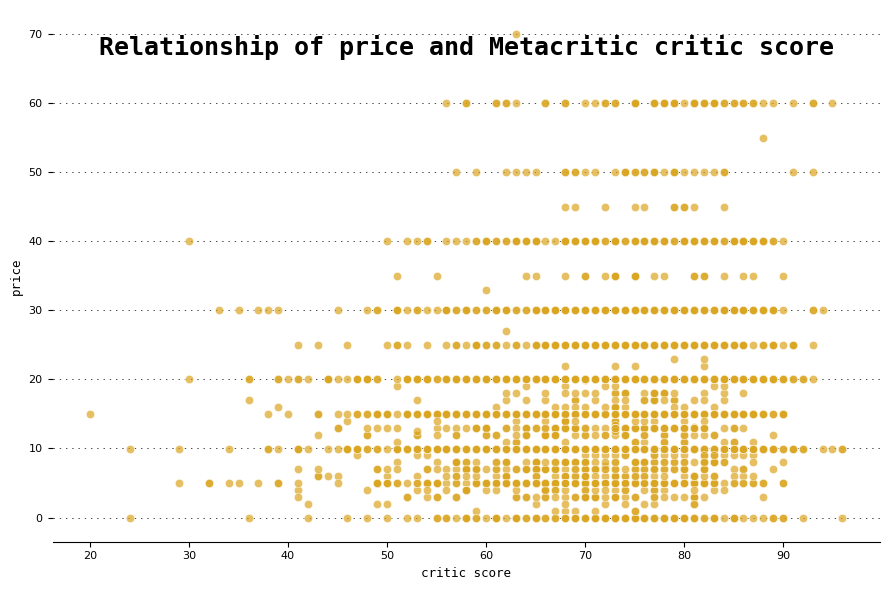

In [39]:
# Check relationship between critic score and price ---
plot.plot_scatter(
    data=df,
    yvar='price_original',
    xvar='metascore',
    title='Relationship of price and Metacritic critic score',
    ylab='price',
    xlab='critic score'
)

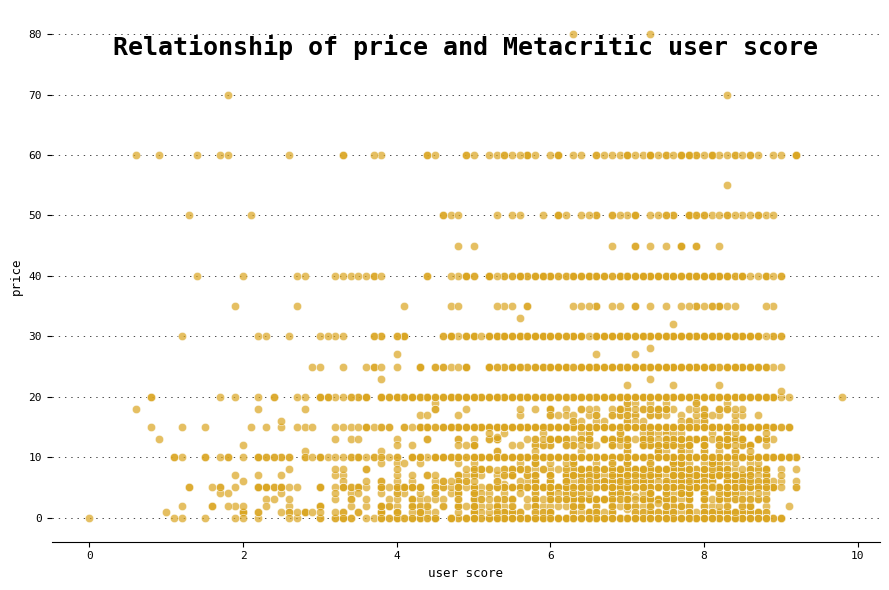

In [134]:
# Check relationship using user scores ---
plot.plot_scatter(
    data=df,
    yvar='price_original',
    xvar='userscore',
    title='Relationship of price and Metacritic user score',
    ylab='price',
    xlab='user score'
)

Conclusions:
* There does not seem to be a strong trend between how high a game's score is and its price -> it would not be suitable to do linear regression on this
* Higher-rated games are not necessarily more expensive
* Although the price of games is a continuous variable, there is definitely a preference to price things in multiples of 5
* There are some overlapping data points in the scatterplot (the darker coloured circles), which may be due to the granular nature of the price variable
* The non-normal distribution of price may also be influencing this relationship
<br></br>

**2.3.4 Best year for video games**  
Which year was the best for new video game releases according to critics and users on Metacritic?

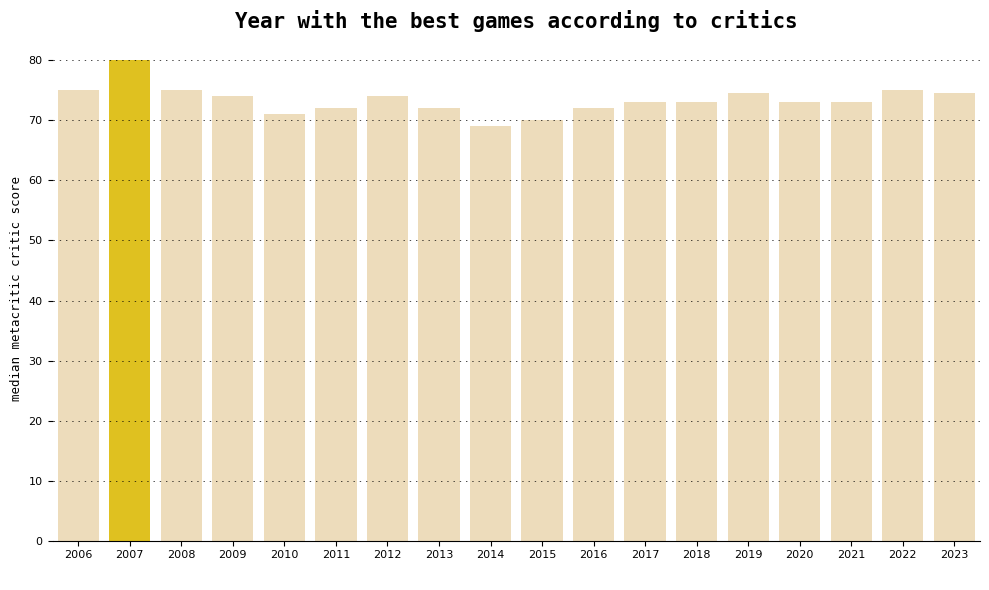

In [41]:
# Year with the best games by Metacritic critic rating ---

df_metascore_medians = df.groupby(df['release_year'])['metascore'].median().reset_index()
df_game_counts = df.groupby(df['release_year'])['title'].count().reset_index()
df_metascore_medians = pd.merge(
    df_metascore_medians, 
    df_game_counts, 
    on='release_year', 
    how='left',
)
df_metascore_medians = df_metascore_medians.rename(
    columns={
        'title': 'n_games', 
        'metascore': 'median_metascore'
    }
)

# filter out years with less than 10 games
df_metascore_medians = df_metascore_medians[df_metascore_medians['n_games'] >= 10].reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
palette1 = ['wheat' for _ in range(len(df_metascore_medians))]
max_median_index = df_metascore_medians['median_metascore'].idxmax()
palette1[max_median_index] = 'gold'

# create the bar plot
sns.barplot(x='release_year', y='median_metascore', data=df_metascore_medians, palette=palette1, ax=ax)

plt.title('Year with the best games according to critics', fontsize=15, fontweight='bold', fontfamily='monospace', loc='center')
ax.set_ylabel('median metacritic critic score', fontsize=9, fontfamily='monospace')
ax.set_xlabel(' ')

ax.grid(which='both', axis='y', linestyle=':', linewidth=0.5, color='black', dashes=(2,7))
ax.tick_params(axis='both', labelsize=8)
for direction in ['top','right','left']:
    ax.spines[direction].set_visible(False)

plt.tight_layout()
plt.show()

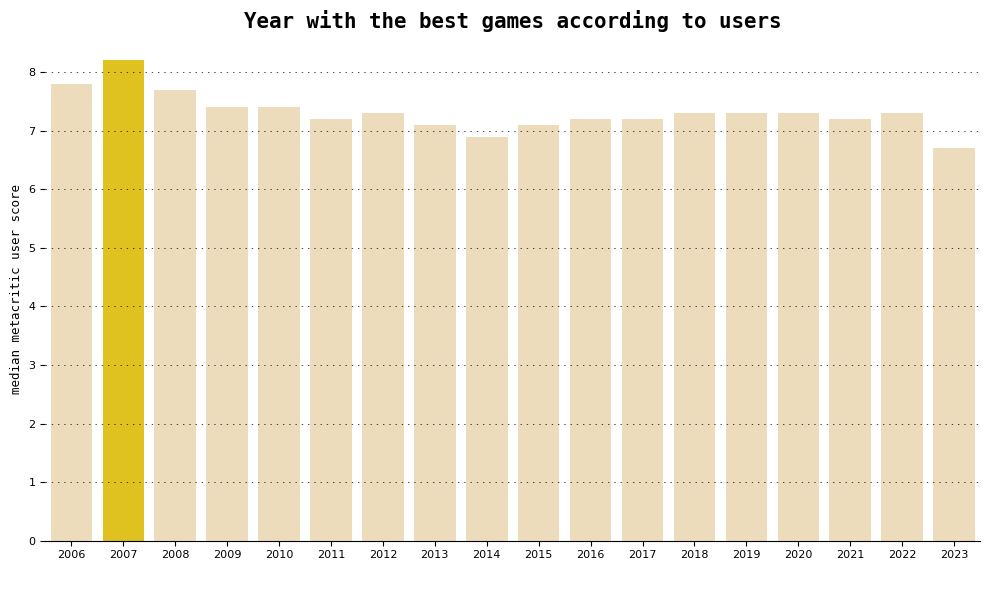

In [42]:
# Year with the best games by Metacritic user rating ---
df['release_year'] = df['date_release'].dt.year
df_userscore_medians = df.groupby(df['release_year'])['userscore'].median().reset_index()
df_game_counts = df.groupby(df['release_year'])['title'].count().reset_index()
df_userscore_medians = pd.merge(
    df_userscore_medians, 
    df_game_counts, 
    on='release_year', 
    how='left',
)
df_userscore_medians = df_userscore_medians.rename(
    columns={
        'title': 'n_games', 
        'userscore': 'median_userscore'
    }
)

# filter out years with less than 10 games
df_userscore_medians = df_userscore_medians[df_userscore_medians['n_games'] >= 10].reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
palette1 = ['wheat' for _ in range(len(df_userscore_medians))]
max_median_index = df_userscore_medians['median_userscore'].idxmax()
palette1[max_median_index] = 'gold'

# create the bar plot
sns.barplot(x='release_year', y='median_userscore', data=df_userscore_medians, palette=palette1, ax=ax)

plt.title('Year with the best games according to users', fontsize=15, fontweight='bold', fontfamily='monospace', loc='center')
ax.set_ylabel('median metacritic user score', fontsize=9, fontfamily='monospace')
ax.set_xlabel(' ')

ax.grid(which='both', axis='y', linestyle=':', linewidth=0.5, color='black', dashes=(2,7))
ax.tick_params(axis='both', labelsize=8)
for direction in ['top','right','left']:
    ax.spines[direction].set_visible(False)

plt.tight_layout()
plt.show()

2007 seems to be the best year for video game releases based both on critic and user feedback! Let's take a look at the top games released in that year:

In [43]:
# Top 10 games in 2007 according to critics ---
print(data_clean.preview_top_x(df[df['release_year'] == 2007], 'metascore', 10))

| title                              |   metascore |
|:-----------------------------------|------------:|
| Half-Life 2                        |          96 |
| Quake                              |          94 |
| Team Fortress 2                    |          92 |
| The Longest Journey                |          91 |
| Portal                             |          90 |
| Half-Life 2: Episode Two           |          90 |
| Return to Castle Wolfenstein       |          88 |
| Hitman 2: Silent Assassin          |          87 |
| Half-Life 2: Episode One           |          87 |
| Company of Heroes: Opposing Fronts |          87 |


In [44]:
# Top 10 games in 2007 according to users ---
print(data_clean.preview_top_x(df[df['release_year'] == 2007], 'userscore', 10))

| title                                |   userscore |
|:-------------------------------------|------------:|
| Portal                               |         9.2 |
| Half-Life 2: Episode Two             |         9.2 |
| Half-Life 2                          |         9.2 |
| Quake III Arena                      |         9   |
| Team Fortress 2                      |         9   |
| DOOM II                              |         8.9 |
| Quake II                             |         8.9 |
| Vampire: The Masquerade - Bloodlines |         8.9 |
| Commandos 2: Men of Courage          |         8.8 |
| DOOM (1993)                          |         8.8 |


Conclusions:
* Everyone seems to agree that 2007 was a golden year for video game releases
* There are 6/10 games that overlap between the critics and users (Half-Life 2, Quake, Team Fortress 2, The Longest Journey, Portal, Half-Life 2: Episode Two)
<br></br>

**2.3.5 Rating in free vs paid games**  

Next, I will check if there is a significant difference in critic and user scores for free vs paid games. I will use a significance level of 0.05 for my hypothesis test.

Hypothesis -  
H0: There is no difference in Metacritic critic score between paid games and free games  
H1: There is a difference in Metacritic critic score between paid games and free games

In [45]:
# Test for critic scores ---
free_games = df[df['is_free']]['metascore']
paid_games = df[df['is_free'] == False]['metascore']

tstat, pvalue = ttest_ind(free_games, paid_games)

if pvalue < 0.05:
    print("Reject null: there is a significant difference in Metacritic critic score between paid and free games.")
else:
    print("Fail to reject null: there is no significant difference in Metacritic critic score between paid and free games.")


Fail to reject null: there is no significant difference in Metacritic critic score between paid and free games.


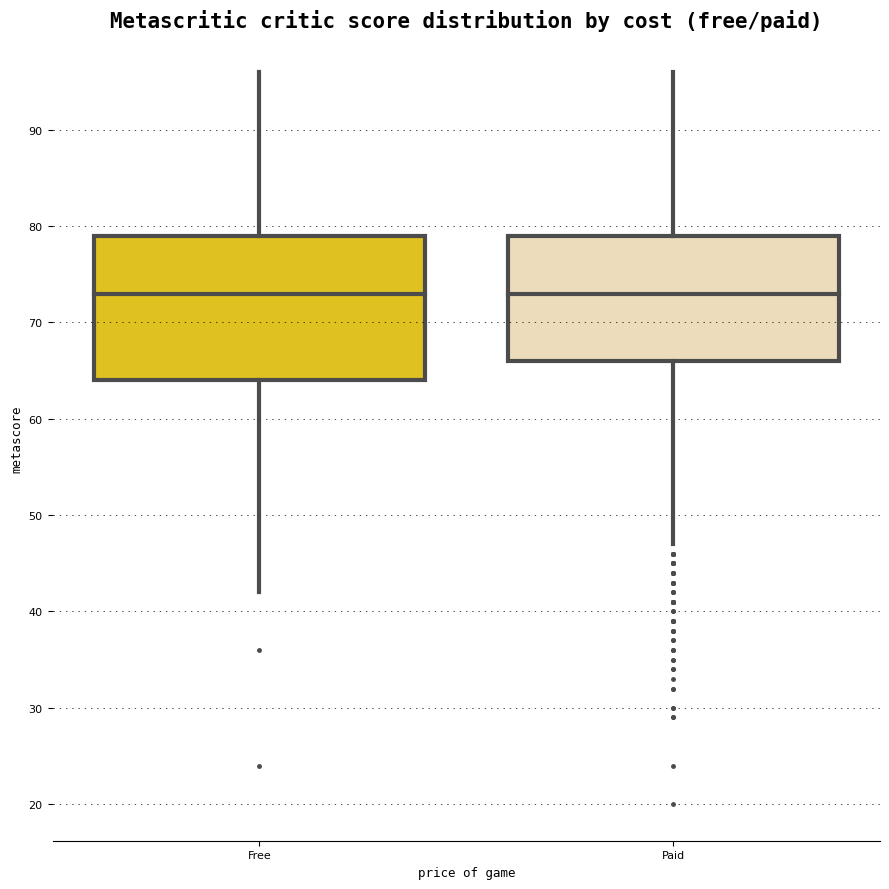

In [46]:
plot.plot_boxplot(
    data=df,
    x='is_free',
    y='metascore',
    xlabels=['Free', 'Paid'],
    title='Metascritic critic score distribution by cost (free/paid)',
    xlab='price of game',
    ylab='metascore'
)

In [47]:
# Test for user scores ---
free_games = df[df['is_free']]['userscore']
paid_games = df[df['is_free'] == False]['userscore']


tstat, pvalue = ttest_ind(free_games, paid_games)

if pvalue < 0.05:
    print("Reject null: there is a significant difference in Metacritic user score between paid and free games.")
else:
    print("Fail to reject null: there is no significant difference in Metacritic user score between paid and free games.")


Fail to reject null: there is no significant difference in Metacritic user score between paid and free games.


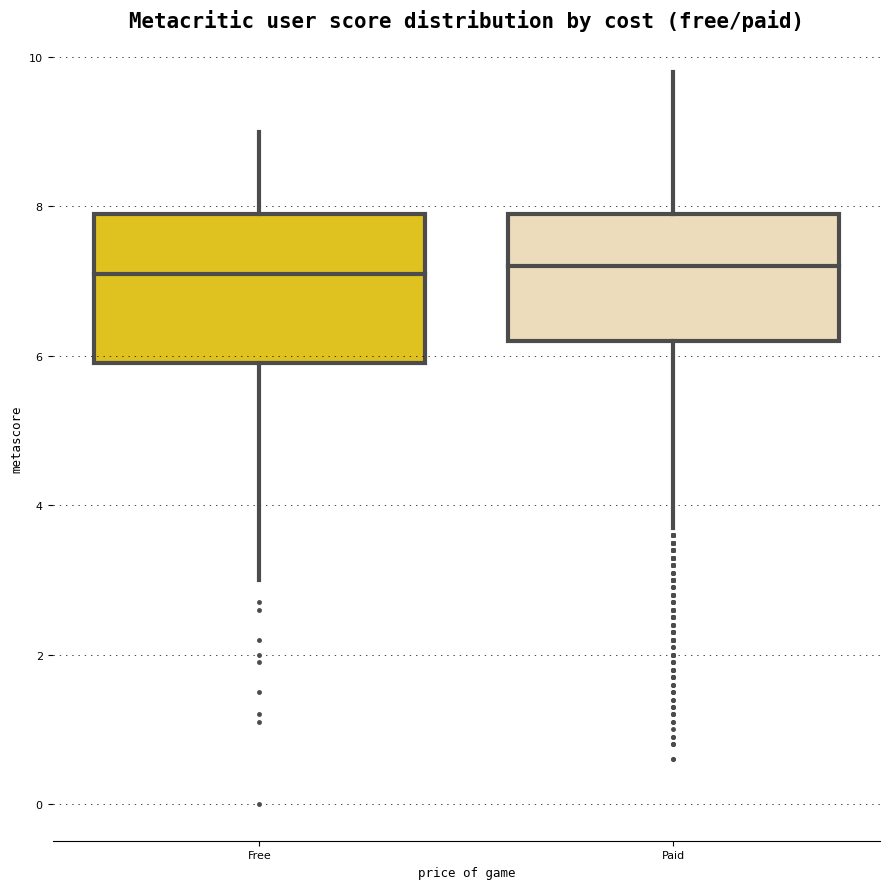

In [48]:
plot.plot_boxplot(
    data=df,
    x='is_free',
    y='userscore',
    xlabels=['Free', 'Paid'],
    title='Metacritic user score distribution by cost (free/paid)',
    xlab='price of game',
    ylab='metascore'
)

Lastly, I will check if there is a difference in free/paid games vs the rating on the Steam store.

H0: There is no relationship between the cost of a game (free/paid) and Steam store ratings for the game (negative/mixed/positive)  
H1: There is a relationship between the cost of a game (free/paid) and Steam store ratings for the game (negative/mixed/positive)

In [121]:
# Test hypothesis on Steam store ratings ---

# simplify outcome to positive, negative, or mixed
rating_groups = [
    df['rating'].str.contains('Positive', case=False),
    df['rating'].str.contains('Negative', case=False)
]
df['rating_tert'] = np.select(rating_groups, ['positive', 'negative'], default='mixed')

# create a contingency table (normalize by row because there are more positive reviews)
contingency_table = pd.crosstab(df['rating_tert'], df['is_free'], normalize='index')

# perform the chi-squared test
chi2_stat, p_value, dof, expected_values = chi2_contingency(contingency_table)

# print results
if p_value < 0.001:
    print(f'There is a strong relationship between the cost of a game and Steam store ratings for the game (p<0.001)')
elif p_value < 0.05:
    print(f'There is a relationship between the cost of a game and Steam store ratings for the game (p={round(p_value, 3)})')
else:
    print(f'There is no relationship between the cost of a game and Steam store ratings for the game (p={round(p_value, 3)})')

There is no relationship between the cost of a game and Steam store ratings for the game (p=0.995)


In [122]:
contingency_table

is_free         False     True 
rating_tert                    
mixed        0.804980  0.195020
negative     0.859924  0.140076
positive     0.831287  0.168713

Conclusions:
* There are no significant differences in Metacritic ratings between free vs paid games
* The median score of critics ratings for free and paid groups are both around 73%
* The median score of user ratings for free and paid groups are both around 7.3 as well
* There are more lower outliers for paid games compared to free games in the critic reviews
* The upper-end of ratings is higher for paid games vs free games in user ratings
* The distribution of the middle 50% of data is slightly tighter for paid games vs free games
* After normalizing, there is no relationship between cost of games (free/paid) and Steam store ratings (negative/mixed/positive); contengency table was normalized to account for the fact that there were more positive reviews overall
<br></br>

### 2.4 Games Over Time

This section will focus on looking for tends in game releases over time.

**2.4.1 Games released per year**  
I will check to see if there are any trends for the number of games released every year.

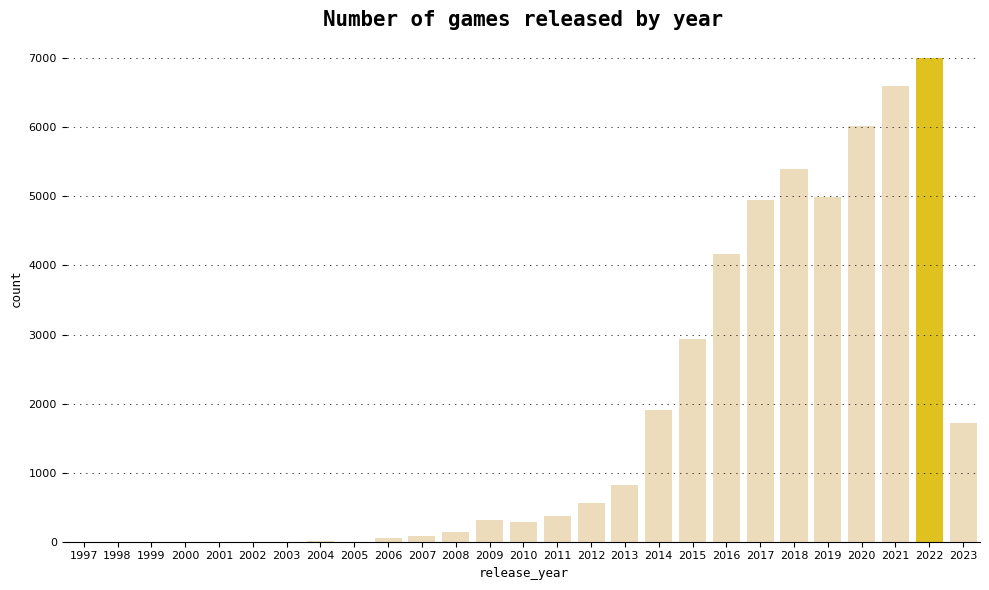

In [50]:
# Number of games released by year ---
plot.plot_counts(
    data=df,
    var_group='release_year',
    var_to_count='title',
    title='Number of games released by year'
)

Conclusions:
* Number of games released are increasing every year, except for 2010 and 2019
* 2022 was the year with the greatest number of games released so far
* 2023 has fewer games compared to 2022, but likely because we are only 1/3 way through the year
<br></br>

**2.4.2 Game release month**  
I am curious if game publishers tend to release more games during certain months (e.g. before holidays).

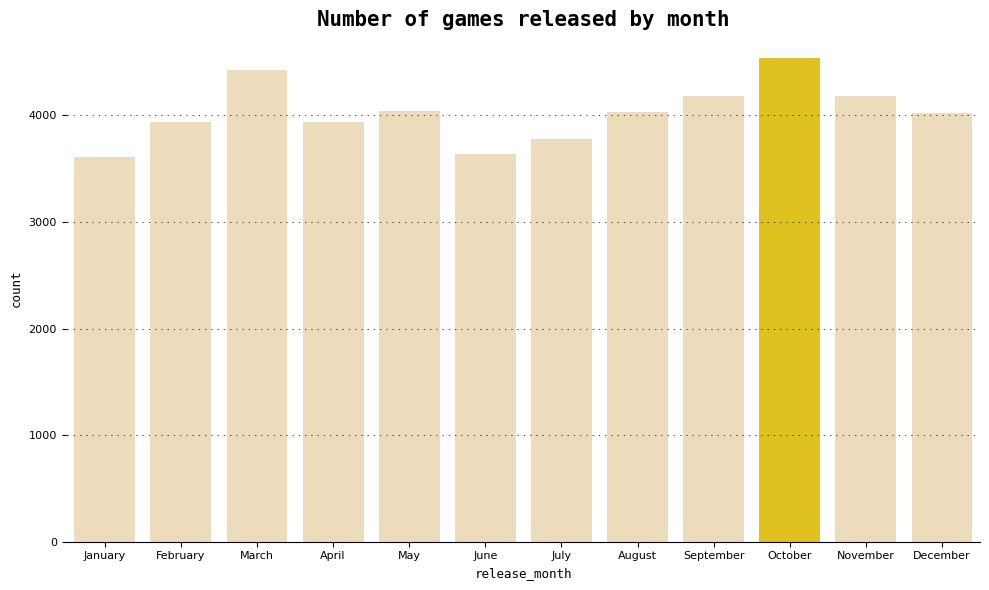

In [51]:
# Number of games released by month ---
plot.plot_counts(
    data=df,
    var_group='release_month',
    var_to_count='title',
    title='Number of games released by month'
)

Conclusions:
* There is a peak in games released in March and October
* October might be in time for Black Friday, and also to prepare for the holidays
* The lowest months for games released is in January and June
<br></br>

**2.4.2 Game release by day of week**  
Lastly, we wil look at if there is a trend in the number of games released on any given day of the week.

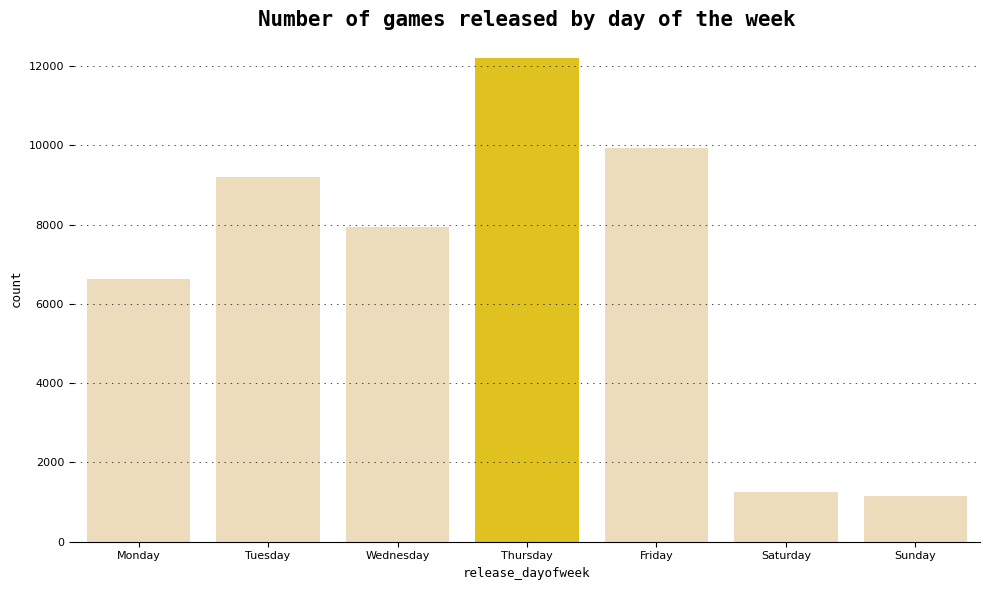

In [52]:
# Number of games released by day of week ---
plot.plot_counts(
    data=df,
    var_group='release_dayofweek',
    var_to_count='title',
    title='Number of games released by day of the week'
)

Conclusion:
* The day most publishers release their game is on Thursday
* Perhaps this is to prepare for the weekend, where people have more time to play games
* There are very few games released on Saturday and Sunday
* Less games released on weekends are likely due to the fact most publishers do not work on weekends
<br></br>

### 2.5 Playtime

The data includes information on the average and median playtime of a game. I will focus on median playtime for the purposes of data exploration because it is more robust to outliers, and I would like to capture trends of the average gamer.

**2.5.1 Games with the highest playtime**

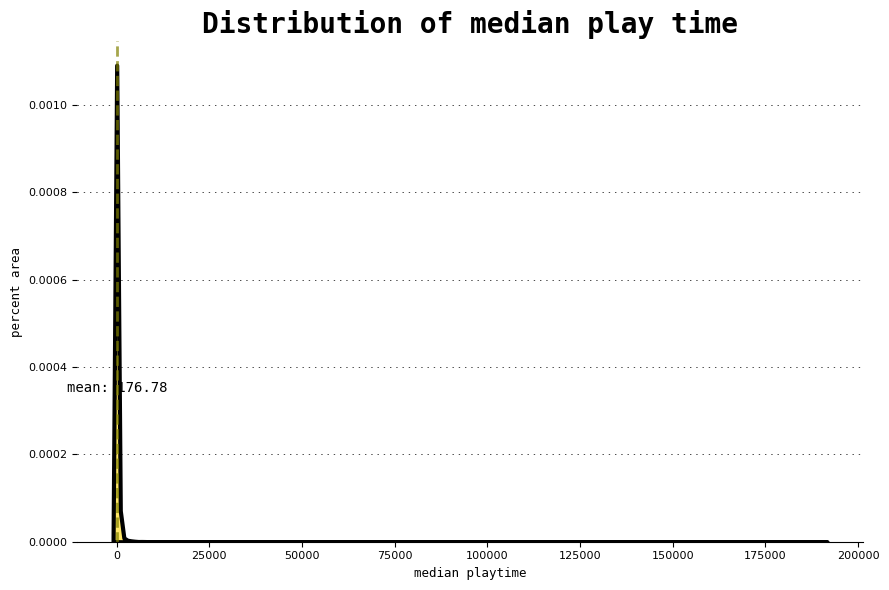

In [53]:
# Density plot of median play time ---
plot.plot_distribution(
    data=df,
    num_var='median_playtime',
    title='Distribution of median play time',
    xlab='median playtime'
)

The playtime of most games seem to be around 177 minutes, but there are a few games that have extremely high playtimes. Let's first check what they are, and then we will remove upper outliers from our analysis and look at the resulting distribution.

In [54]:
print(df.sort_values(by='median_playtime', ascending=False)[['title', 'median_playtime', 'rating']].head(10).to_markdown(index=False))

| title                                  |   median_playtime | rating          |
|:---------------------------------------|------------------:|:----------------|
| The Abbey of Crime Extensum            |            190625 | Very Positive   |
| The Secret of Tremendous Corporation   |            190445 | Very Positive   |
| 懒人修仙传                             |             71857 | Mixed           |
| PRICE                                  |             63490 | Very Positive   |
| Boundless                              |             55204 | Mostly Positive |
| Shroud of the Avatar: Forsaken Virtues |             54618 | Mixed           |
| X-Plane 11                             |             44169 | Very Positive   |
| Screeps: World                         |             38805 | Very Positive   |
| The Price of Freedom                   |             36029 | Positive        |
| MANDAGON                               |             31845 | Very Positive   |


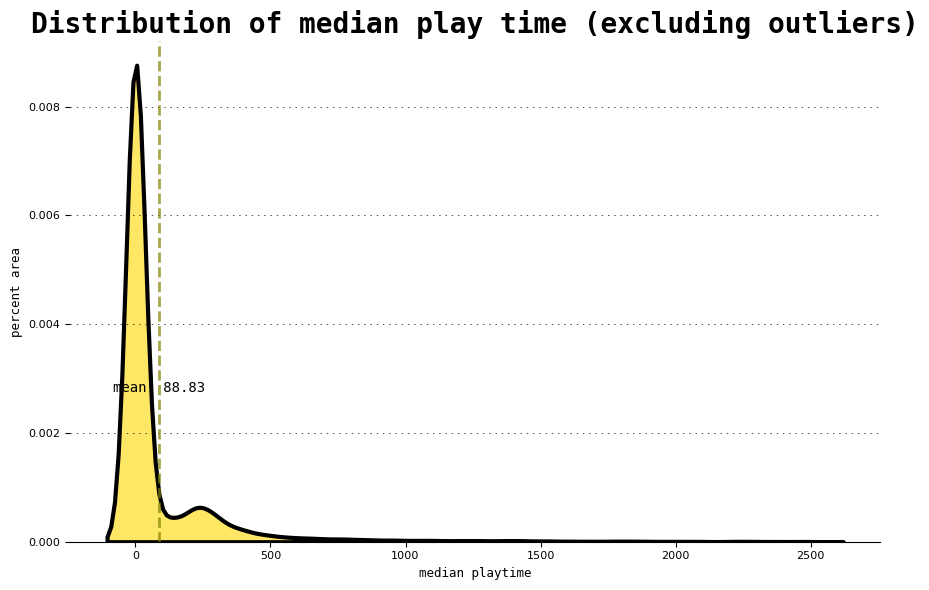

In [55]:
# exclude games >1 std from the mean
playtime_xoutliers = data_clean.remove_upper_outliers(df, 'median_playtime', 1)

plot.plot_distribution(
    data=playtime_xoutliers,
    num_var='median_playtime',
    title='Distribution of median play time (excluding outliers)',
    xlab='median playtime'
)

The average playtime is now around 89 min, but there are still many games with much higher playtimes.

In [56]:
print(playtime_xoutliers.sort_values(by='median_playtime', ascending=False)[['title', 'median_playtime', 'rating']].head(10).to_markdown(index=False))

| title                                                  |   median_playtime | rating          |
|:-------------------------------------------------------|------------------:|:----------------|
| Governor of Poker 3                                    |              2515 | Mostly Positive |
| Call of Duty®: Black Ops III                           |              2513 | Very Positive   |
| Disciples III - Renaissance Steam Special Edition      |              2486 | Mixed           |
| SpellForce 2: Faith in Destiny                         |              2481 | Mixed           |
| METAL GEAR SOLID V: THE PHANTOM PAIN                   |              2478 | Very Positive   |
| Star Trek Timelines                                    |              2473 | Mixed           |
| FINAL FANTASY VIII                                     |              2470 | Very Positive   |
| SAO Utils: Beta                                        |              2455 | Very Positive   |
| DARK SOULS™ II: Scholar of t

Conclusions:
* Most games have a playtime of approximately 89 minutes
* There are a few games with a very dedicated fanbase that result in a max of 190625 minutes of playtime
* Games with very high playtimes (outliers) tend to have a mixture of reviews, between mixed to very positive
* Surprisingly, games with high playtimes are not necessarily all "very positive"
<br></br>

**2.5.2 Effect of achievement on playtime**  
I hypothesize that games with more achievements might result in longer playtimes, as gamers might spend longer in the game trying to achieve everything.

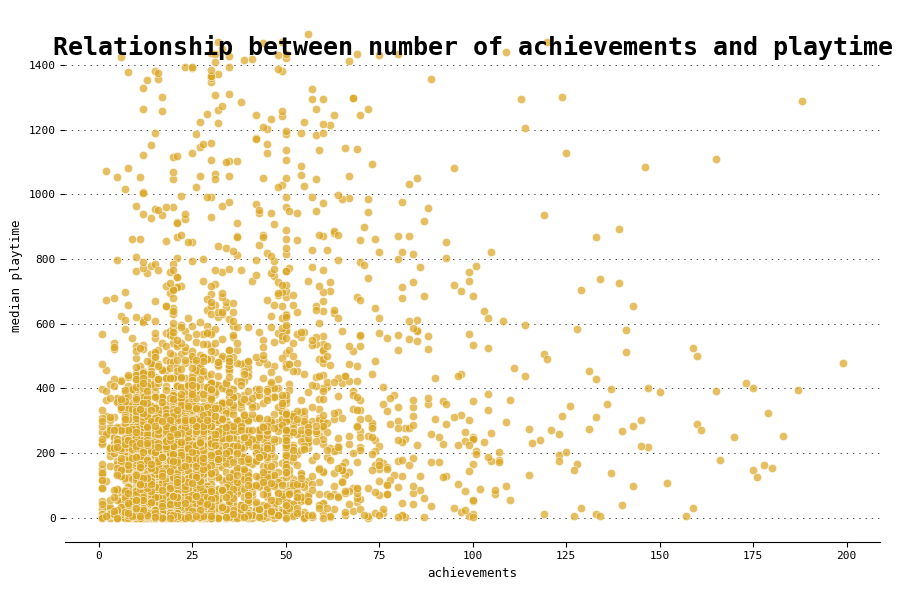

In [133]:
# Scatterplot of achievement and median playtime ---

# focus on the lower end of data, since both achievement and playtime are heavily right-skewed
# remove 0s as we are not interested in nulls
extreme_cond = (
    ((df['median_playtime'] > 0) & (df['median_playtime'] < 1500)) &
    ((df['achievements'] > 0) & (df['achievements'] < 200))
)
df_xextremes = df[extreme_cond]

plot.plot_scatter(
    df_xextremes,
    'achievements',
    'median_playtime',
    'Relationship between number of achievements and playtime',
    'achievements',
    'median playtime'
)

Conclusions:
* There does not seem to be a clear relationship between number of achievements and median playtime, even after removing extremes

<br></br>

## 3. MACHINE LEARNING MODELS
---

### 3.1 Predicting Ratings

I want to see if I will be able to predict the rating of a newly released game based on my data. The rating will be one of the categories from the Steam Store: 'Very Positive', 'Positive', 'Mixed', 'Mostly Positive', 'Overwhelmingly Positive', 'Mostly Negative', 'Overwhelmingly Negative', 'Negative', or 'Very Negative'. I will simplify these outcomes to 'Positive' and 'Not Positive'. I combined mixed and negative for two reasons: (1) there are more positively rated games than negatively rated games so I wanted to balance the classes, and (2) game developers would be interested in knowing if they can achieve a positive review for their game.

In [57]:
# Recall the data ---
print(data_clean.preview_data(df))

|   app_id | title                             | date_release        | win   | mac   | linux   | rating        |   positive_ratio |   user_reviews |   price_final |   price_original |   discount | steam_deck   | english   | developer         | publisher         |   required_age | categories                                                                                                                                                                                                         | genres                                 | steamspy_tags              |   achievements |   positive_ratings |   negative_ratings |   average_playtime |   median_playtime | owners          |   metascore |   userscore |   release_year | release_month   | release_dayofweek   | is_free   | rating_tert   |
|---------:|:----------------------------------|:--------------------|:------|:------|:--------|:--------------|-----------------:|---------------:|--------------:|-----------------:|-----------:|:--------

In [58]:
# Set up data for classifier model ---

# set up index columns
index_cols = ['app_id', 'title']

# add rating_bi: simplify outcome to positive and not_positive
rating_cond = [
    df['rating'].str.contains('Positive', case=False)
]
df['rating_bi'] = np.select(rating_cond, ['positive'], default='not_positive')

# only keep the main developer & publisher (first value that appears in the column)
df['developer'] = df['developer'].str.split(';').str[0]
df['publisher'] = df['publisher'].str.split(';').str[0]

# get dummies
cols_to_dummy_withsc = ['categories', 'genres'] # has semicolon separaters
cols_to_dummy = ['developer', 'publisher', 'release_month', 'release_dayofweek']

dummy_dfs = []
for col in cols_to_dummy_withsc + cols_to_dummy:
    prefix = ''
    if col == 'categories':
        prefix = 'cat_'
    elif col == 'genres':
        prefix = 'genre_'
    elif col == 'developer':
        prefix = 'dev_'
    elif col == 'publisher':
        prefix = 'pub_'
    dummy_df = df[col].str.get_dummies(';').astype(bool) if col in cols_to_dummy_withsc else pd.get_dummies(df[col], dummy_na=False)
    dummy_df.columns = [prefix + str(c) for c in dummy_df.columns]
    dummy_dfs.append(dummy_df)

df_clf = pd.concat([df] + dummy_dfs, axis=1)

# change 0/1 columns to boolean for consistency
df_clf['win'] = df_clf['win'].astype(bool)
df_clf['mac'] = df_clf['mac'].astype(bool)
df_clf['linux'] = df_clf['linux'].astype(bool)
df_clf['steam_deck'] = df_clf['steam_deck'].astype(bool)
df_clf['english'] = df_clf['english'].astype(bool)

# clean up column naming convention
df_clf.columns = df_clf.columns.str.lower().str.replace(' ', '_')

# Features that are not useful will be ignored. This includes features that are not helpful (e.g. release date 
# and year won't be future-looking), and information that would not be available to a newly released game (e.g. 
# user reviews, positive ratios, playtime, owners, scores).
cols_to_ignore = [
    'date_release', 
    'release_year', 
    'positive_ratio',
    'user_reviews',
    'price_final',
    'discount',
    'steamspy_tags',
    'positive_ratings',
    'negative_ratings',
    'average_playtime',
    'median_playtime',
    'owners',
    'metascore',
    'userscore',
    'rating',
    'rating_cat',
    'rating_tert'
]
df_clf = df_clf.drop(columns=cols_to_ignore, errors='ignore')
df_clf = df_clf.drop(columns=cols_to_dummy_withsc, errors='ignore')
df_clf = df_clf.drop(columns=cols_to_dummy, errors='ignore')

df_clf = df_clf.dropna(axis=1, how='all')

# clean up nans - attempt to maximize training data by dropping a mixture of rows and columns
# drop features if they contain >20% missingness
# drop rows for the remaining missing values
df_clf = data_clean.clean_missing(df_clf, 'app_id')

FEATURES WITH >20% MISSINGNESS
required_age is being dropped with 29711 missing values
achievements is being dropped with 29711 missing values

Before: 20760 features
After: 20758 features
2 features dropped

DROP IDS WITH MISSINGNESS

Before: 48318 ids
After: 48318 ids
0 ids dropped

The DataFrame is clean
Final data contains 20758 features and 48318 ids 


In [59]:
# Preview output ---
data_clean.print_shape(df_clf, 'df_clf')
print()
print('Preview data:')
print(data_clean.preview_data(df_clf))

The dataframe 'df_clf' has 48318 rows and 20758 columns.

Preview data:
|   app_id | title                             | win   | mac   | linux   |   price_original | steam_deck   | english   | is_free   | rating_bi    | cat_captions_available   | cat_co-op   | cat_commentary_available   | cat_cross-platform_multiplayer   | cat_full_controller_support   | cat_in-app_purchases   | cat_includes_source_sdk   | cat_includes_level_editor   | cat_local_co-op   | cat_local_multi-player   | cat_mmo   | cat_mods   | cat_mods_(require_hl2)   | cat_multi-player   | cat_online_co-op   | cat_online_multi-player   | cat_partial_controller_support   | cat_shared/split_screen   | cat_single-player   | cat_stats   | cat_steam_achievements   | cat_steam_cloud   | cat_steam_leaderboards   | cat_steam_trading_cards   | cat_steam_turn_notifications   | cat_steam_workshop   | cat_steamvr_collectibles   | cat_vr_support   | cat_valve_anti-cheat_enabled   | genre_accounting   | genre_action   | genre_adventure

In [60]:
# Check if there are any unexpected non-boolean columns ---

non_bool_cols = df_clf.select_dtypes(exclude='bool').columns.tolist()
print(non_bool_cols)

['app_id', 'title', 'price_original', 'rating_bi']


In [61]:
# Check if there are any duplicate app_ids ---
data_clean.check_duplicate_ids(df_clf, 'app_id')

Data is clean, each row is a unique app_id.


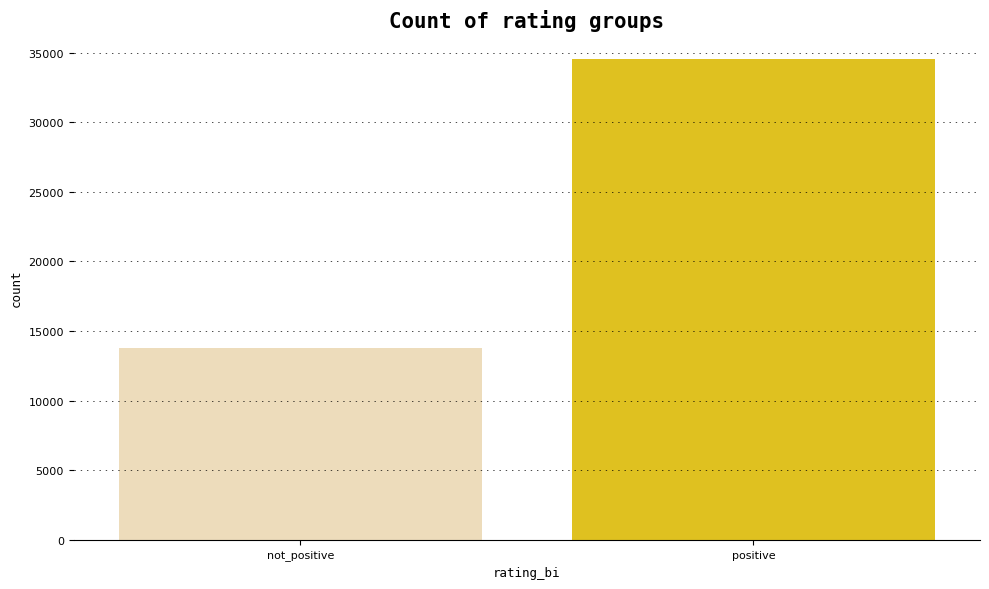

In [62]:
# Check distribution of outcome classes ---

plot.plot_counts(
    data=df_clf, 
    var_group='rating_bi', 
    var_to_count='app_id',
    title='Count of rating groups'
)

Even with the clustering of negative and mixed, there are many more positively rated games compared to the other outcomes. This will be important to keep in mind, as the classifier might err on the side of predicting a new game as "positive" to maximize accuracy.

In [63]:
# Set up X and y ---
X = df_clf.drop(columns=['app_id', 'title', 'rating_bi'])
y = df_clf['rating_bi']

# split the data into training and testing sets (10% test)
X_training, X_test, y_training, y_test = train_test_split(
    X, y, test_size=0.1, random_state=14
)

# split the training set into training (80%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(
    X_training, y_training, test_size=0.125, random_state=14
)

Next I will preliminarily train a random forest model to get an idea of the data.

In [64]:
# Train a random forest classifier ---
rf_test = RandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=14)
rf_test.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, random_state=14)

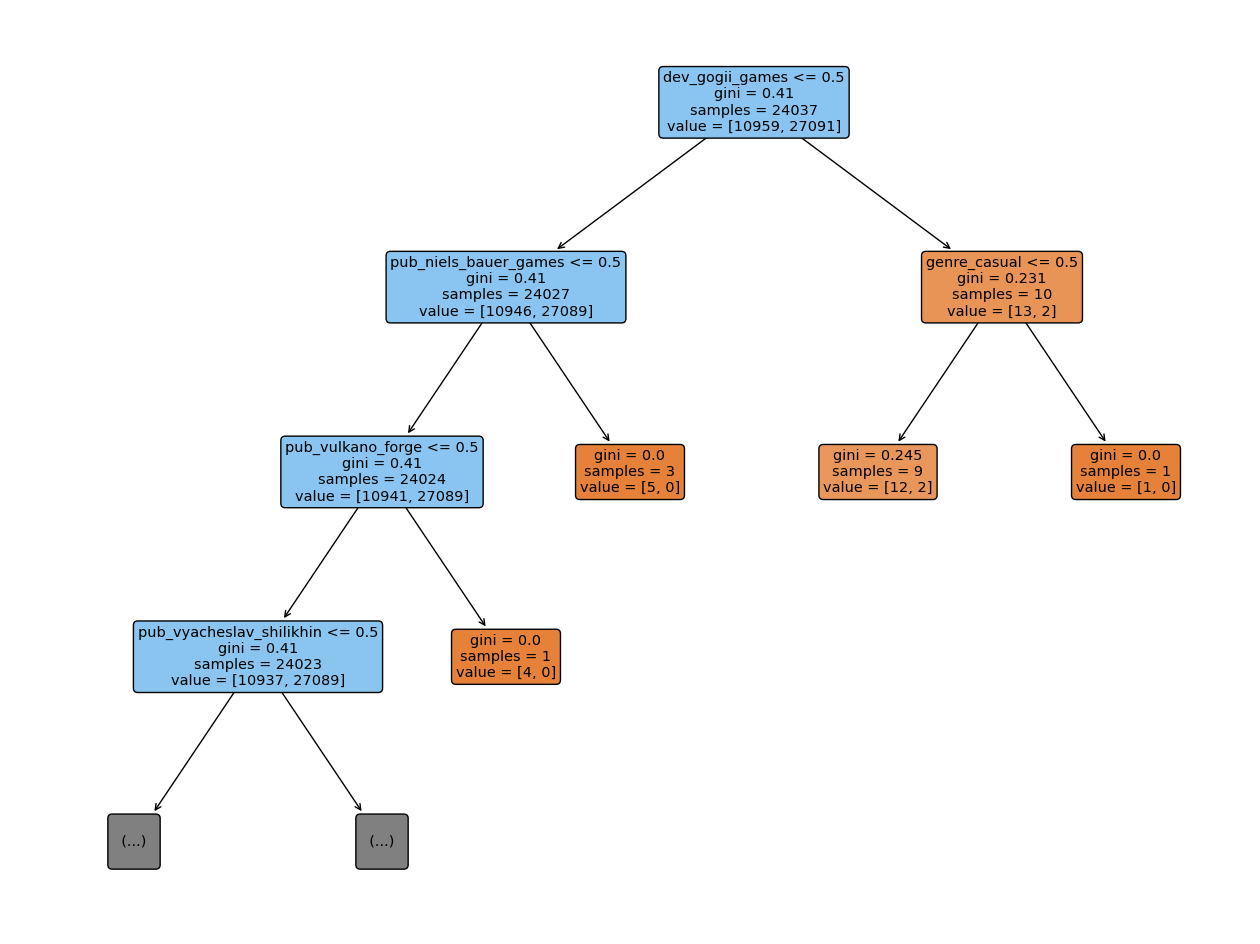

In [65]:
# Plot an example (using preliminary parameters) ---
# the first decision tree from the forest showing max of 3 levels to reduce processing time
tree = rf_test.estimators_[0]

plt.figure(figsize=(16, 12))
plot_tree(
    tree, 
    max_depth=3,
    feature_names=X_train.columns, 
    filled=True,
    rounded=True
)
plt.show()

In [66]:
# Make predictions on the validation set ---
y_pred = rf_test.predict(X_val)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print('Accuracy of rf_test:', accuracy)

Accuracy of rf_test: 0.7205665930831494


This preliminary model has an accuracy of 72% on the validation set. Let's see if we can improve our model with hyperparameter tuning.

In [67]:
# Hyperparameter tuning: random search ---
# note: this takes around 35 minutes to run
param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': randint(10, 80),
    'min_samples_split': randint(2, 30)
}

# set up random search with 5 iterations
rand_search = RandomizedSearchCV(
    rf_test, 
    param_distributions=param_dist, 
    n_iter=5, 
    cv=5, 
    random_state=14
)

# fit the random search to the data
rand_search.fit(X_train, y_train)

# create a variable for the best model
rf_best = rand_search.best_estimator_

# print the best parameters and score
print(f"Best parameters found: {rand_search.best_params_}")
print(f"Best accuracy score: {rand_search.best_score_}")


Best parameters found: {'max_depth': 71, 'min_samples_split': 10, 'n_estimators': 76}
Best accuracy score: 0.7223915900131406


In [68]:
# Train a random forest classifier using results from tuning ---
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=71, min_samples_split=10, n_estimators=76,
                       random_state=14)

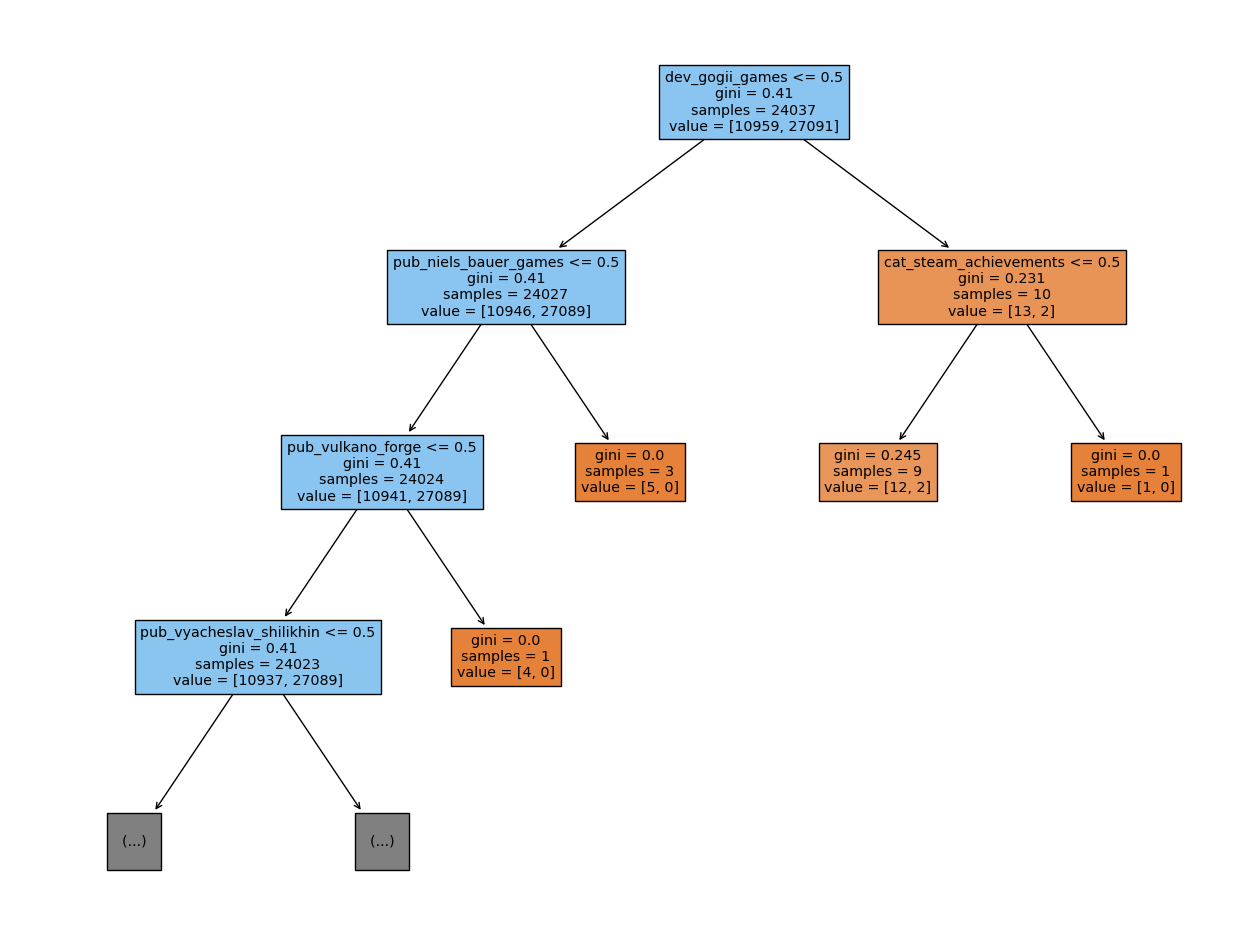

In [69]:
# Plot an example (using best parameters) ---
# the first decision tree from the forest showing max of 3 levels to reduce processing
tree = rf_best.estimators_[0]

plt.figure(figsize=(16, 12))
plot_tree(tree, max_depth=3, feature_names=X_train.columns, filled=True)
plt.show()

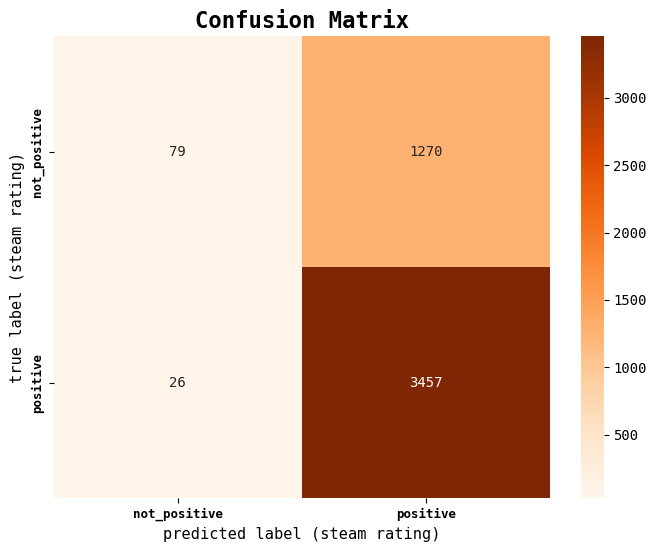

In [70]:
mpl.rcParams['font.family'] = 'monospace'

# Generate predictions with the best model
y_pred = rf_best.predict(X_test)

# Create the confusion matrix
class_names = rf_best.classes_
cm = confusion_matrix(y_test, y_pred, labels=class_names)

# Plot confusion matrix with rotated labels and larger figure size
fig, ax = plt.subplots(figsize=(8, 6))

plt.title('Confusion Matrix', fontweight='bold', fontfamily='monospace', fontsize=16)
plt.xticks(fontsize=9, fontfamily='monospace', fontweight='bold')
plt.yticks(fontsize=9, fontfamily='monospace', fontweight='bold')
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Oranges', 
    xticklabels=class_names, 
    yticklabels=class_names
)
ax.set_ylabel('true label (steam rating)', fontsize=11, fontfamily='monospace')
ax.set_xlabel('predicted label (steam rating)', fontsize=11, fontfamily='monospace')
plt.show()

From the confusion matrix, we can see some issues with class imbalance in our model. Many not_positive rated games were predicted incorrectly. I believe this is partially due to the small number of games were had negative ratings in our training set realtive to the positively rated games. The model tries to optimize accuracy and makes more Type I errors.

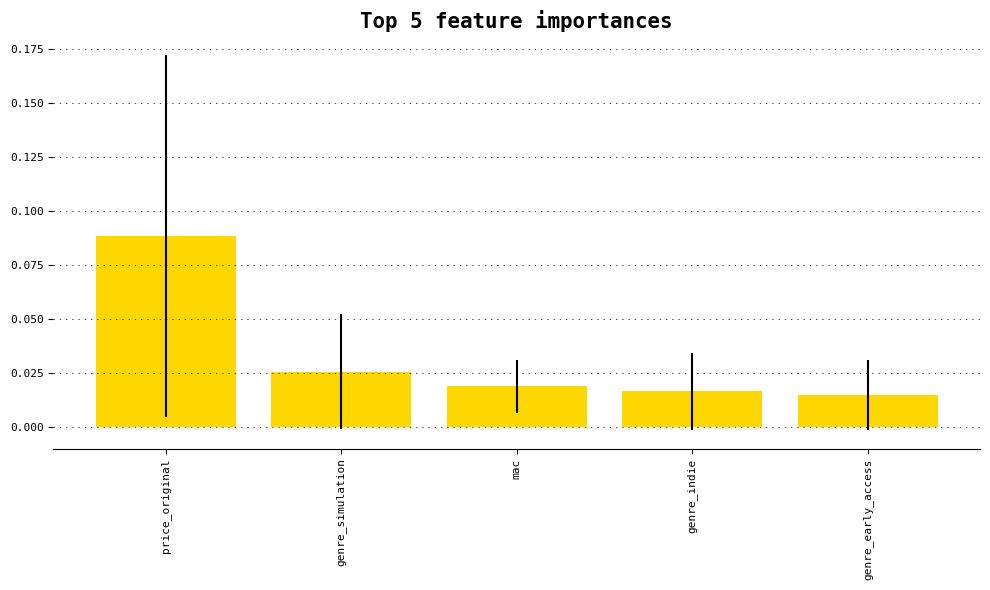

In [71]:
# Get feature importances from the trained random forest ---
importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:5]  # only show top 5 features

# plot feature importances as a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
plt.title('Top 5 feature importances', fontsize=15, fontweight='bold', fontfamily='monospace', loc='center')
plt.bar(range(len(indices)), importances[indices], yerr=std[indices], align="center", color='gold')
plt.xticks(range(len(indices)), X_train.columns[indices], rotation='vertical')

ax.grid(which='both', axis='y', linestyle=':', linewidth=0.5, color='black', dashes=(2,7))
ax.tick_params(axis='both', labelsize=8)
for direction in ['top','right','left']:
    ax.spines[direction].set_visible(False)

plt.tight_layout()
plt.show()

Conclusions and findings:
* Model has accuracy of ~72%
* There are many more games that are positively rated compared to negatively rated, which may affect results of classifiation even though random forest is one of the better models to counter this.
* The most important features to classify a game into the positive or not-positive rating seems to be the price of the game, but the standard error of the predictors are large.
<br></br>

### 3.2 Predicting Recommendations

I want to see if I can predict if a new review in the Steam store would recommend a game based on the game in question (app_id), hours played, number of games the user already own, and the number of reviews the user have already written. I will do this using logistic regression since I have used random forest for the previous section. However, given more time, I would like to repeat this analysis using random forest to compare the outcome.

In [72]:
# Recall what the data looks like ---
print(data_clean.preview_data(df_user))

|   app_id |   helpful |   funny | date                | is_recommended   |   hours |   user_id |   review_id |   products |   reviews |
|---------:|----------:|--------:|:--------------------|:-----------------|--------:|----------:|------------:|-----------:|----------:|
|   975370 |         0 |       0 | 2022-12-12 00:00:00 | True             |    36.3 |     21058 |           0 |         28 |         3 |
|   304390 |         4 |       0 | 2017-02-17 00:00:00 | False            |    11.5 |      1153 |           1 |        269 |         1 |
|  1085660 |         2 |       0 | 2019-11-17 00:00:00 | True             |   336.5 |     96124 |           2 |        237 |         2 |
|   703080 |         0 |       0 | 2022-09-23 00:00:00 | True             |    27.4 |     98074 |           3 |          5 |         2 |
|   526870 |         0 |       0 | 2021-01-10 00:00:00 | True             |     7.9 |      9634 |           4 |         13 |         2 |


In [73]:
# Clean up any missingness ---
df_log = data_clean.clean_missing(df_user, 'review_id')

FEATURES WITH >20% MISSINGNESS

Before: 10 features
After: 10 features
0 features dropped

DROP IDS WITH MISSINGNESS

Before: 11265799 ids
After: 11265799 ids
0 ids dropped

The DataFrame is clean
Final data contains 10 features and 11265799 ids 


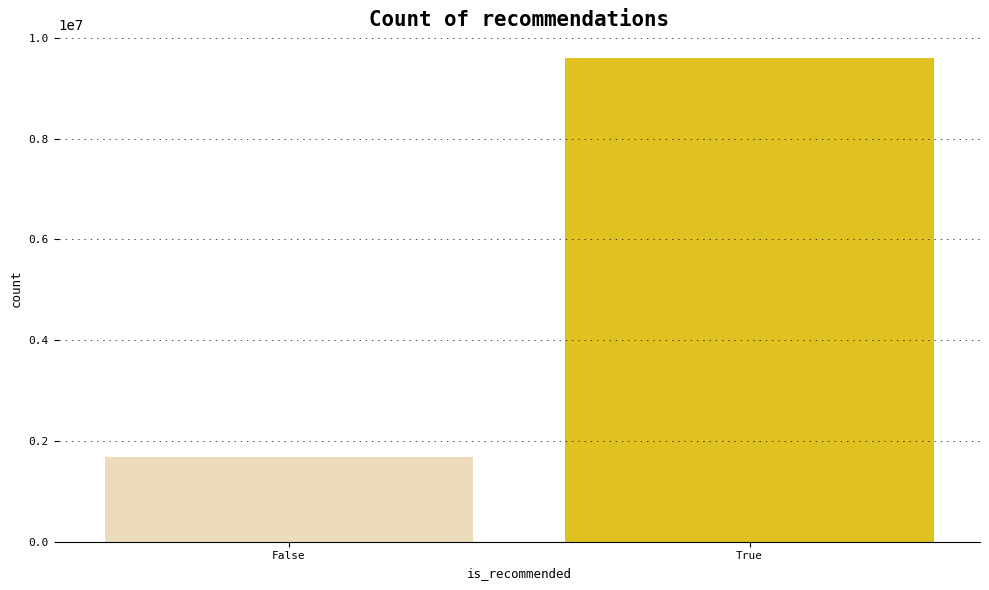

In [74]:
# Check distribution of outcome classes ---

plot.plot_counts(
    data=df_log, 
    var_group='is_recommended', 
    var_to_count='review_id',
    title='Count of recommendations'
)

We need to be careful with the imbalance of classes. Logistic regression is unfortunately sensitive to class imbalance.

Next we will set up X and y. For logistic regression, I chose to scale my X variables since they are all in different units.

In [75]:
# Set up X and y ---

X = df_log[['app_id', 'hours', 'products', 'reviews']]
y = df_log['is_recommended']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

# separate the numerical and categorical features
num_features = ['hours', 'products', 'reviews']
cat_features = ['app_id']

# create the scaler for the numerical and categorical data
num_scaler = StandardScaler()
cat_scaler = OneHotEncoder()

# combine the numerical and categorical scaler into data_scaler
data_scaler = ColumnTransformer(
    transformers=[
        ('num', num_scaler, num_features),
        ('cat', cat_scaler, cat_features)
    ]
)

# scale training and test data
X_train_scaled = data_scaler.fit_transform(X_train)
X_test_scaled = data_scaler.transform(X_test)

In [76]:
# Logistic regression ---

lr = LogisticRegression(solver='liblinear', random_state=14)
lr.fit(X_train_scaled, y_train)

LogisticRegression(random_state=14, solver='liblinear')

In [77]:
# Assess accuracy ---

y_pred = lr.predict(X_test_scaled)

accuracy = lr.score(X_test_scaled, y_test)
print(f"Accuracy of logistic regression: {accuracy}")

Accuracy of logistic regression: 0.8520761952102824


This is quite a high accuracy score, but I suspect is because of the class imbalance we are seeing. Let's next examine the confusion matrix to check.

In [78]:
# Generate confusion matrix ---
cm_log = confusion_matrix(
	y_test, y_pred,
	labels=df_log['is_recommended'].unique()
)
labels=df_log['is_recommended'].unique()
cm_clean = pd.DataFrame(cm_log, index=labels, columns=labels)
print("Confusion matrix:")
print(cm_clean)

Confusion matrix:
         True   False
True   1903340  15136
False   318160  16524


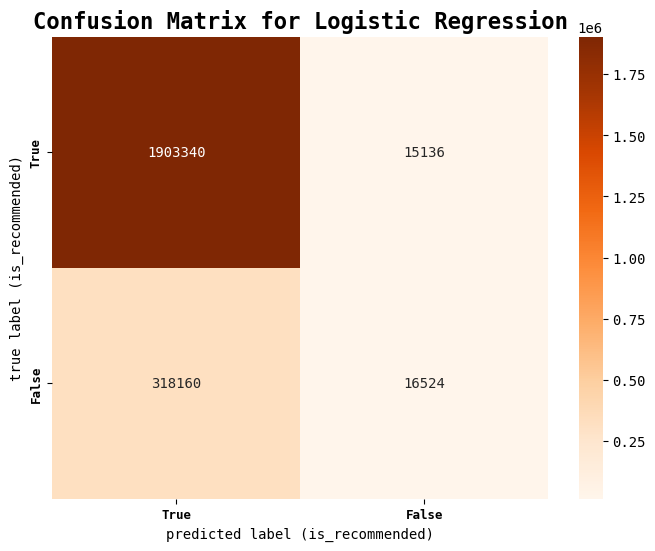

In [79]:
mpl.rcParams['font.family'] = 'monospace'

# Plot confusion matrix with rotated labels and larger figure size
fig, ax = plt.subplots(figsize=(8, 6))

plt.title('Confusion Matrix for Logistic Regression', fontweight='bold', fontfamily='monospace', fontsize=16)
plt.xticks(fontsize=9, fontfamily='monospace', fontweight='bold')
plt.yticks(fontsize=9, fontfamily='monospace', fontweight='bold')
sns.heatmap(
    cm_clean, 
    annot=True, 
    fmt='d', 
    cmap='Oranges', 
    xticklabels=labels, 
    yticklabels=labels
)
ax.set_ylabel('true label (is_recommended)', fontsize=10, fontfamily='monospace')
ax.set_xlabel('predicted label (is_recommended)', fontsize=10, fontfamily='monospace')
plt.show()

In [80]:
# Print classification report ---
print(f"Classification report:\n {classification_report(y_test, y_pred)}")

Classification report:
               precision    recall  f1-score   support

       False       0.52      0.05      0.09    334684
        True       0.86      0.99      0.92   1918476

    accuracy                           0.85   2253160
   macro avg       0.69      0.52      0.50   2253160
weighted avg       0.81      0.85      0.80   2253160



Conclusions and interpretation:
* Model has a high accuracy of ~85%, but there are caveats
* Precision is the ratio of true positives (TP) to the total predicted positive values (true positives + false positives). The precision of the "False" class is 0.52, meaning that 52% of the predicted positives for this class were actually true positives (not great)
* Recall is the ratio of TPs to the total actual positive values (true positives + false negatives). The recall of the "False" class is 0.05, meaning that only 5% of the actual positives for this class were correctly predicted as positives (again, not great)
* The f1-score is the harmonic mean of precision and recall. It is a metric that combines both precision and recall into a single value. The f1-score of the "False" class is 0.09, which is a low value (also not good).
* Support is the number of instances in each outcome class
* Accuracy is the ratio of the number of correct predictions to the total number of predictions
* Macro avg is the average precision, recall, and f1-score across both classes. The macro avg precision is 0.69, the macro avg recall is 0.52, and the macro avg f1-score is 0.50.
* Weighted avg is the weighted average of precision, recall and f1-score across both classes. The weighted avg precision is 0.81, the weighted avg recall is 0.85, and the weighted avg f1-score is 0.80.

Overall, the model has a high accuracy and performs well on the "True" class, but it has a lower performance on the "False" class. This is very likely due to the imbalance of outcome classes. There were many more "recommend"s compared to "not recommend"s in our training data.
<br></br>

### 3.3 Bag-of-words

I hope to use the write-up 'about the game' to predict the genre of the game. Perhaps this can be used to automate genre classification when a new game is released.

In [81]:
# Recall the data ---
print(data_clean.preview_data(df_descript))

|   steam_appid | detailed_description                                                                                                                                                                                                                                                                                                                                                                                                                         | about_the_game                                                                                                                                                                                                                                                                                                                                                                                                                               | short_description                                                                                                       

In [82]:
# Clean up any missingness ---
df_nb = data_clean.clean_missing(df_descript, 'steam_appid')

FEATURES WITH >20% MISSINGNESS
metascore is being dropped with 13086 missing values
userscore is being dropped with 11067 missing values

Before: 9 features
After: 7 features
2 features dropped

DROP IDS WITH MISSINGNESS

Before: 15375 ids
After: 15375 ids
0 ids dropped

The DataFrame is clean
Final data contains 7 features and 15375 ids 


The outcome column (genres) is quite messy; there are multiple genres per game. I would like to focus on the main genre, but unfortunately that information is not available in the data (the column seems to be sorted in alphabetical order). I will instead select one random genre from each game to use as my outcome.

In [83]:
# Clean up y ---
# selected a random genre from the list provided (did not pick first because it is alphabetical)
df_nb['genre'] = df_nb['genres'].apply(data_clean.select_random_value)

In [84]:
# Set up X and y ---

# apply the text preprocessing function to the text columns in X
text_cols = ['detailed_description', 'about_the_game', 'short_description']
for col in text_cols:
    df_nb[col] = df_nb[col].apply(data_clean.preprocess_text)

# create the document-term matrix (X)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_nb['about_the_game'])

# create the dependent variable (y)
y = df_nb['genre']

# split the data into training and testing sets (20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

In [85]:
# Train a Naive Bayes classifier ---
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [86]:
# Make predictions on the test data ---
y_pred = nb.predict(X_test)

# evaluate the performance of the classifier
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.35252032520325205


Conclusions:
* The bag-of-words and multinomial model are poor predictors of genre based on `about_the_game` write-up
* Accuracy is only ~36%
* However, this is likely due to the quality of data, as one game has multiple genres; ideally, I would like to focus on the main genre for prediction but the data was not available
* There may also be things I missed during text preprocessing
* Other text columns may be more useful for prediction
<br></br>

### 3.4 Improvements for Models

There are a few factors that can be changed to improve on the current analysis that I was not able to get to due to time restraints or lack of knowledge:
* Test a wider variety of models before hyperparameter tuning in random forest model
* Attempt to balance outcome classes more for all models
* Test out more classification models in addition to random forest and logistic regression
* Repeat the logistic regression for recommending games using random forest
* If there was a way to pick a "main" genre for each game, the bag-of-words classifier may perform better
* Use more than 1 text column for bag-of-words analysis (e.g. add in the description columns); I wasn't too sure how to do this
* Spend longer pre-processing the text for bag-of-words analysis to eliminate common words
* Graph loss function to determine if model is over- or under-fitting
* Run feature selection on models to simplify them

<br></br>

## 4. FUTURE DIRECTIONS
---

Given more time, knowledge, and experience, there are many other machine learning tasks I would love to try with this data. For example:

* Are we able to identify any influential games in each genre and its impact on future game releases?
* What are the factors that determine the price of a game? Can we predict game price for future games?
* Predict the number of positive ratings a game will receive (regression task); however, we lack detailed information on precise number of game owners at the moment.
* Build a game recommendation system for users, perhaps by cluster games based on genre, tags, and user reviews.
* Perform a different type of text classification on the game titles and descriptions to predict the categories, genres, or tags associated with each game. This might improve the tagging system for new games.
* Perform anomaly detection to identify games that have a significantly higher or lower rating than expected based on their attributes.

<br></br>

## 5. ACKNOWLEDGEMENTS AND THANKS
---

Thank you to Kaggle for providing the data for this analysis. Lots of thanks to Zubia and Jason for answering all my questions and teaching us for the last 10 weeks, it has been such a great learning process! Lastly, thank you to all the students in the course for learning together. I hope we can all keep in touch after this course!